Loading session data from: /Users/yamachang/Desktop/theta-meditation-project/data/test_session/1748578178.42679
Current version: 0.2.5
EEG data shape: (209340, 6)
Transposed data to shape: (6, 209340)
Visualizing 92160 samples (720.0 seconds)
Quick filtering...


/var/folders/d3/9ly5k4s50pn98c5j4xljd3h00000gn/T/ipykernel_81711/2097634796.py:69: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim(-data_range*1.2, data_range*1.2)


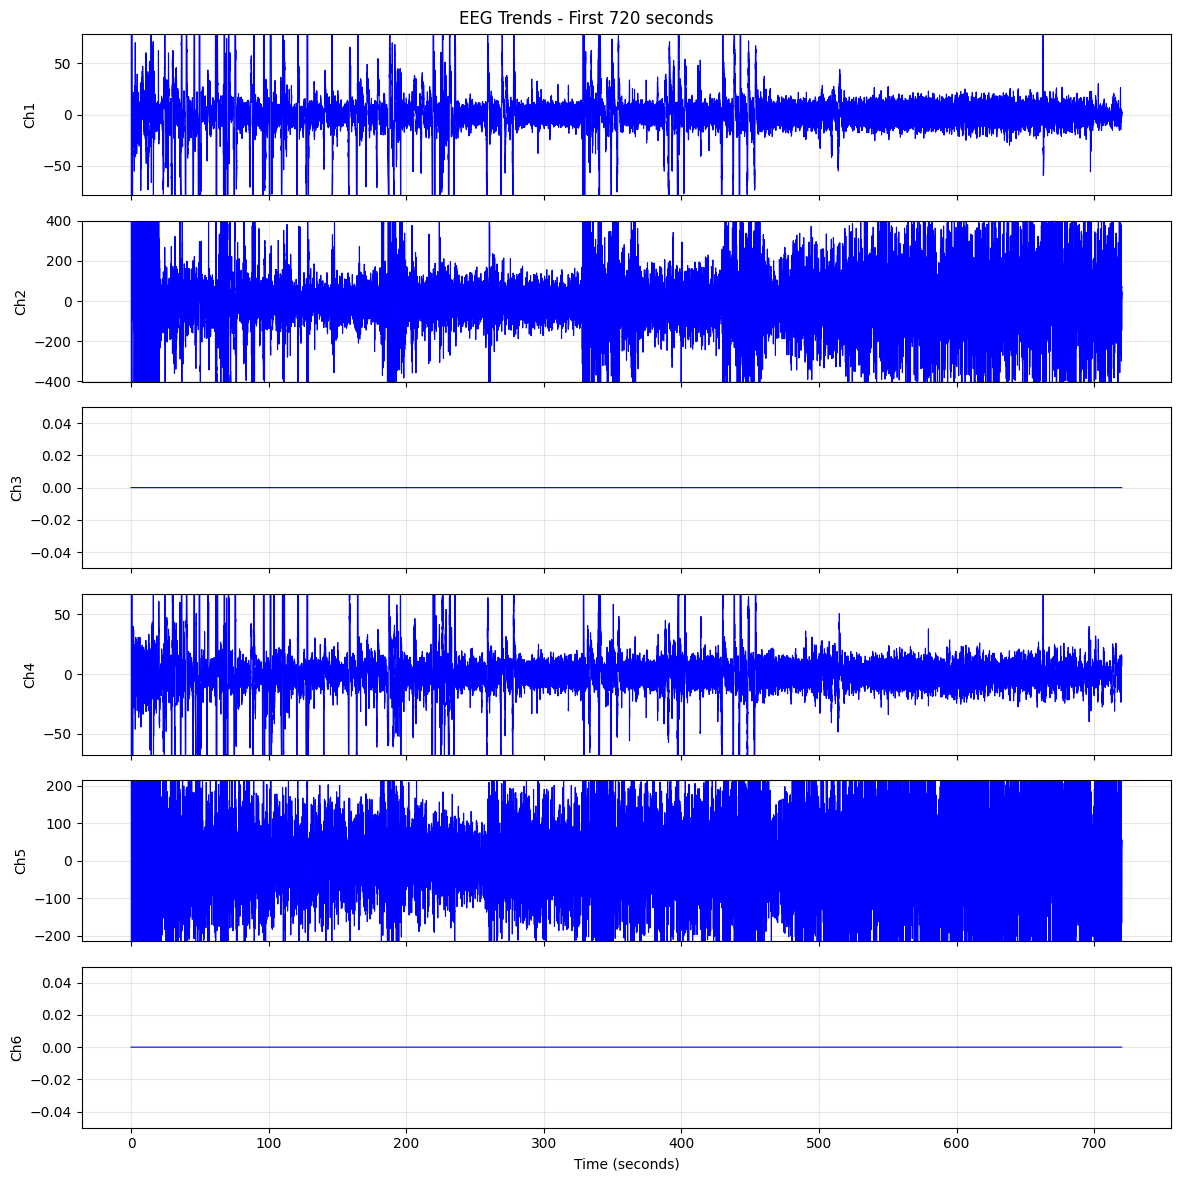

Quick visualization complete!


In [ ]:
# Fast EEG Visualization Script
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
import os
import sys

# Add project path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the load_experiment function
from frenztoolkit.reader import load_experiment

# Configuration
SESSION_PATH = "/Users/yamachang/Downloads/neurozen_v6/data/DEID_Participants/DEID_P5/Session_1/1748972897.5852458"
FS_EEG = 128  # EEG sampling rate
CHANNEL_NAMES = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6']
VIZ_DURATION_SEC = 720  # Only visualize first 60 seconds for speed

def quick_filter(data, fs):
    """Quick bandpass filter for visualization"""
    # Simple 2nd order bandpass filter 1-30 Hz
    sos = butter(2, [1.0, 30.0], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data, axis=0)  # Filter along time axis

def plot_eeg_quick(eeg_data, fs, channel_names, duration_sec=60):
    """Quick EEG visualization"""
    
    # Get data dimensions and handle shape
    if eeg_data.shape[0] > eeg_data.shape[1]:
        # Data is (samples, channels) - transpose to (channels, samples)
        eeg_data = eeg_data.T
        print(f"Transposed data to shape: {eeg_data.shape}")
    
    num_channels, num_samples = eeg_data.shape
    
    # Limit to visualization duration
    max_samples = min(int(duration_sec * fs), num_samples)
    data_subset = eeg_data[:, :max_samples]
    
    print(f"Visualizing {max_samples} samples ({max_samples/fs:.1f} seconds)")
    
    # Quick filtering on subset only
    print("Quick filtering...")
    filtered_subset = quick_filter(data_subset.T, fs).T  # Transpose for filtering, then back
    
    # Create time vector
    time_vec = np.arange(max_samples) / fs
    
    # Plot
    fig, axes = plt.subplots(num_channels, 1, figsize=(12, 2 * num_channels), sharex=True)
    if num_channels == 1:
        axes = [axes]
    
    for i in range(num_channels):
        ch_name = channel_names[i] if i < len(channel_names) else f"Ch{i+1}"
        
        # Plot filtered data only (for speed)
        axes[i].plot(time_vec, filtered_subset[i, :], 
                    color='blue', linewidth=0.8, label=f'{ch_name} Filtered')
        
        axes[i].set_ylabel(f'{ch_name}')
        axes[i].grid(True, alpha=0.3)
        
        # Simple y-limits
        data_range = np.percentile(np.abs(filtered_subset[i, :]), 95)
        axes[i].set_ylim(-data_range*1.2, data_range*1.2)
    
    axes[-1].set_xlabel('Time (seconds)')
    plt.suptitle(f'EEG Trends - First {duration_sec} seconds', fontsize=12)
    plt.tight_layout()
    plt.show()

def main():
    # Load session data
    print(f"Loading session data from: {SESSION_PATH}")
    session_data = load_experiment(SESSION_PATH)
    
    # Extract EEG data
    eeg_data = session_data["DATA"]["RAW"]["EEG"]
    print(f"EEG data shape: {eeg_data.shape}")
    
    # Quick visualization
    plot_eeg_quick(eeg_data, FS_EEG, CHANNEL_NAMES, VIZ_DURATION_SEC)
    
    print("Quick visualization complete!")

if __name__ == "__main__":
    main()

Loaded config: FS_EEG=125, Active channels: ['LF', 'RF', 'OTEL', 'OTER']
Successfully imported signal_utils functions.
Loading session data from: /Users/yamachang/Downloads/neurozen_v6/data/DEID_Participants/DEID_P5/Session_1/1748972897.5852458
Current version: 0.2.6
EEG data shape: (225126, 6)
Transposed EEG data to shape: (6, 225126)
Processing subset: (6, 225000) (1800.0 seconds)
Processing (6, 225000) EEG data through fast causal pipeline...
  Processing channel 1/6
  Processing channel 2/6
  Processing channel 3/6
  Processing channel 4/6
  Processing channel 5/6
  Processing channel 6/6
Processing completed in 13.85 seconds

=== Processing Statistics ===
Overall artifact rate: 1.84%
Epoch quality: 433/450 good epochs

Per-channel artifact rates:
  Ch1: 1.07% artifacts
  Ch2: 3.86% artifacts
  Ch3: 0.00% artifacts
  Ch4: 1.68% artifacts
  Ch5: 4.46% artifacts
  Ch6: 0.00% artifacts


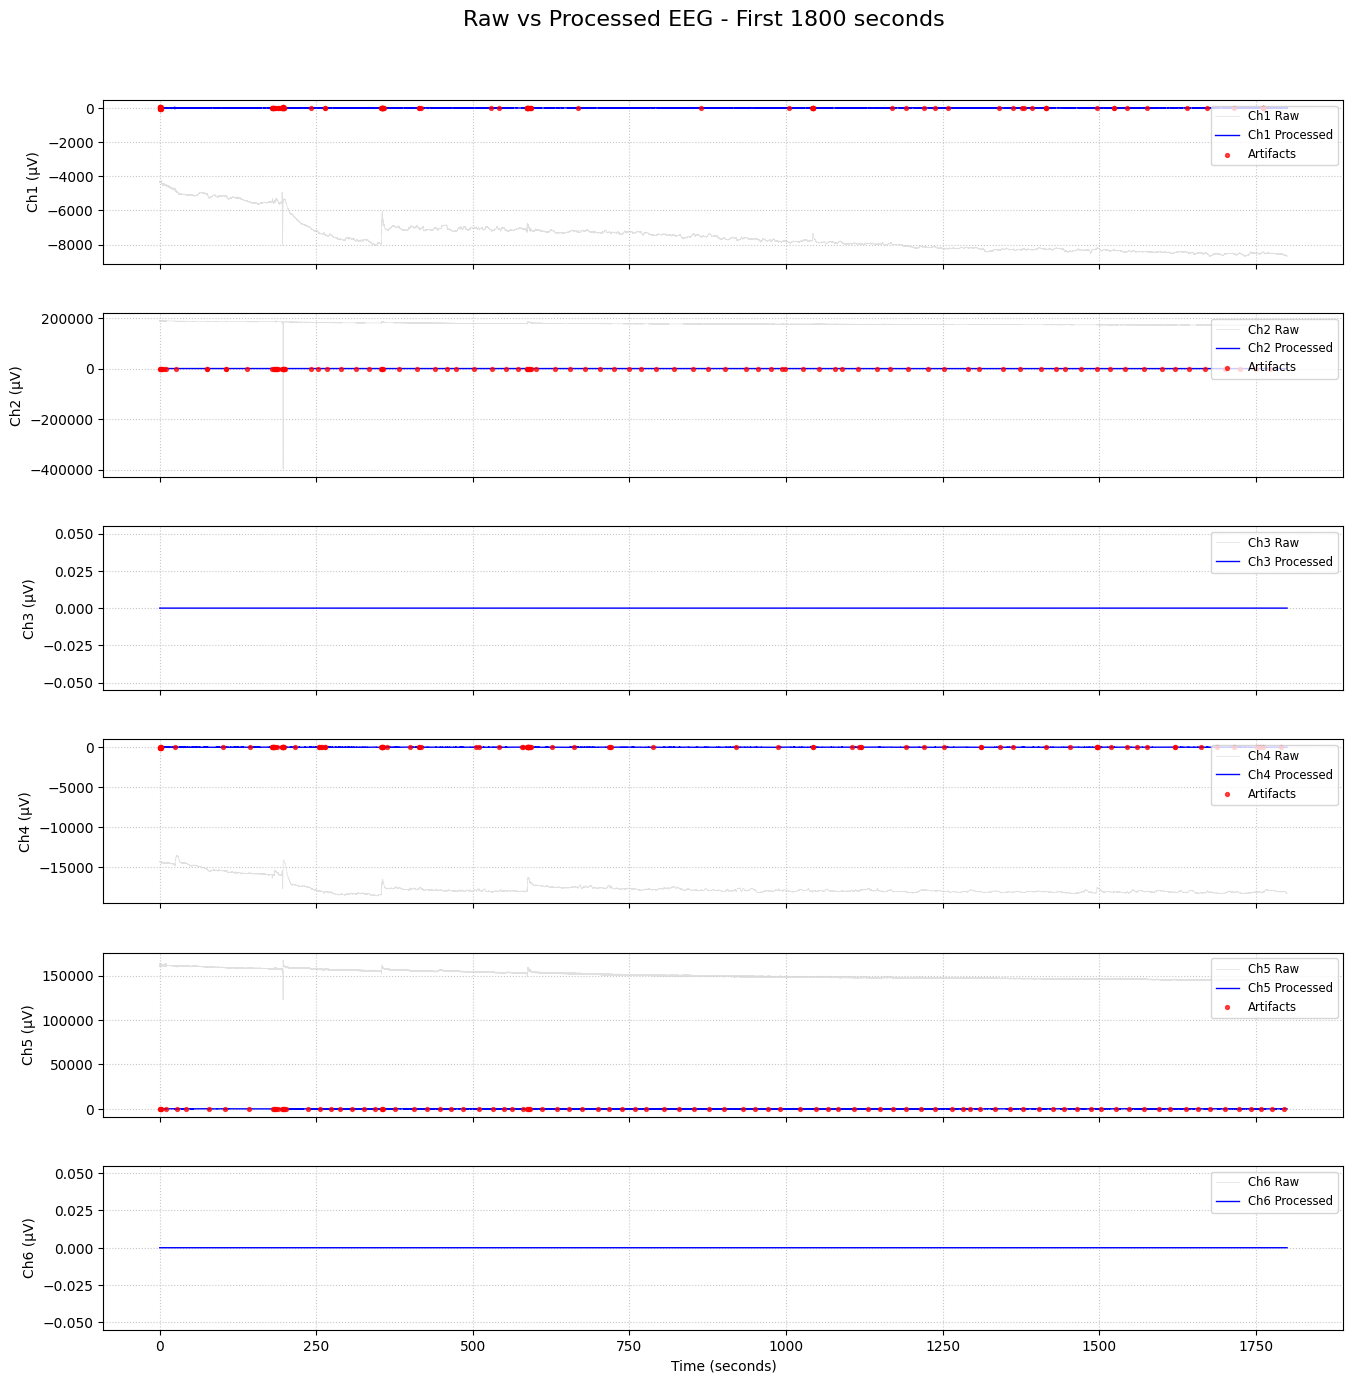

Calculating band powers over 1800 seconds...


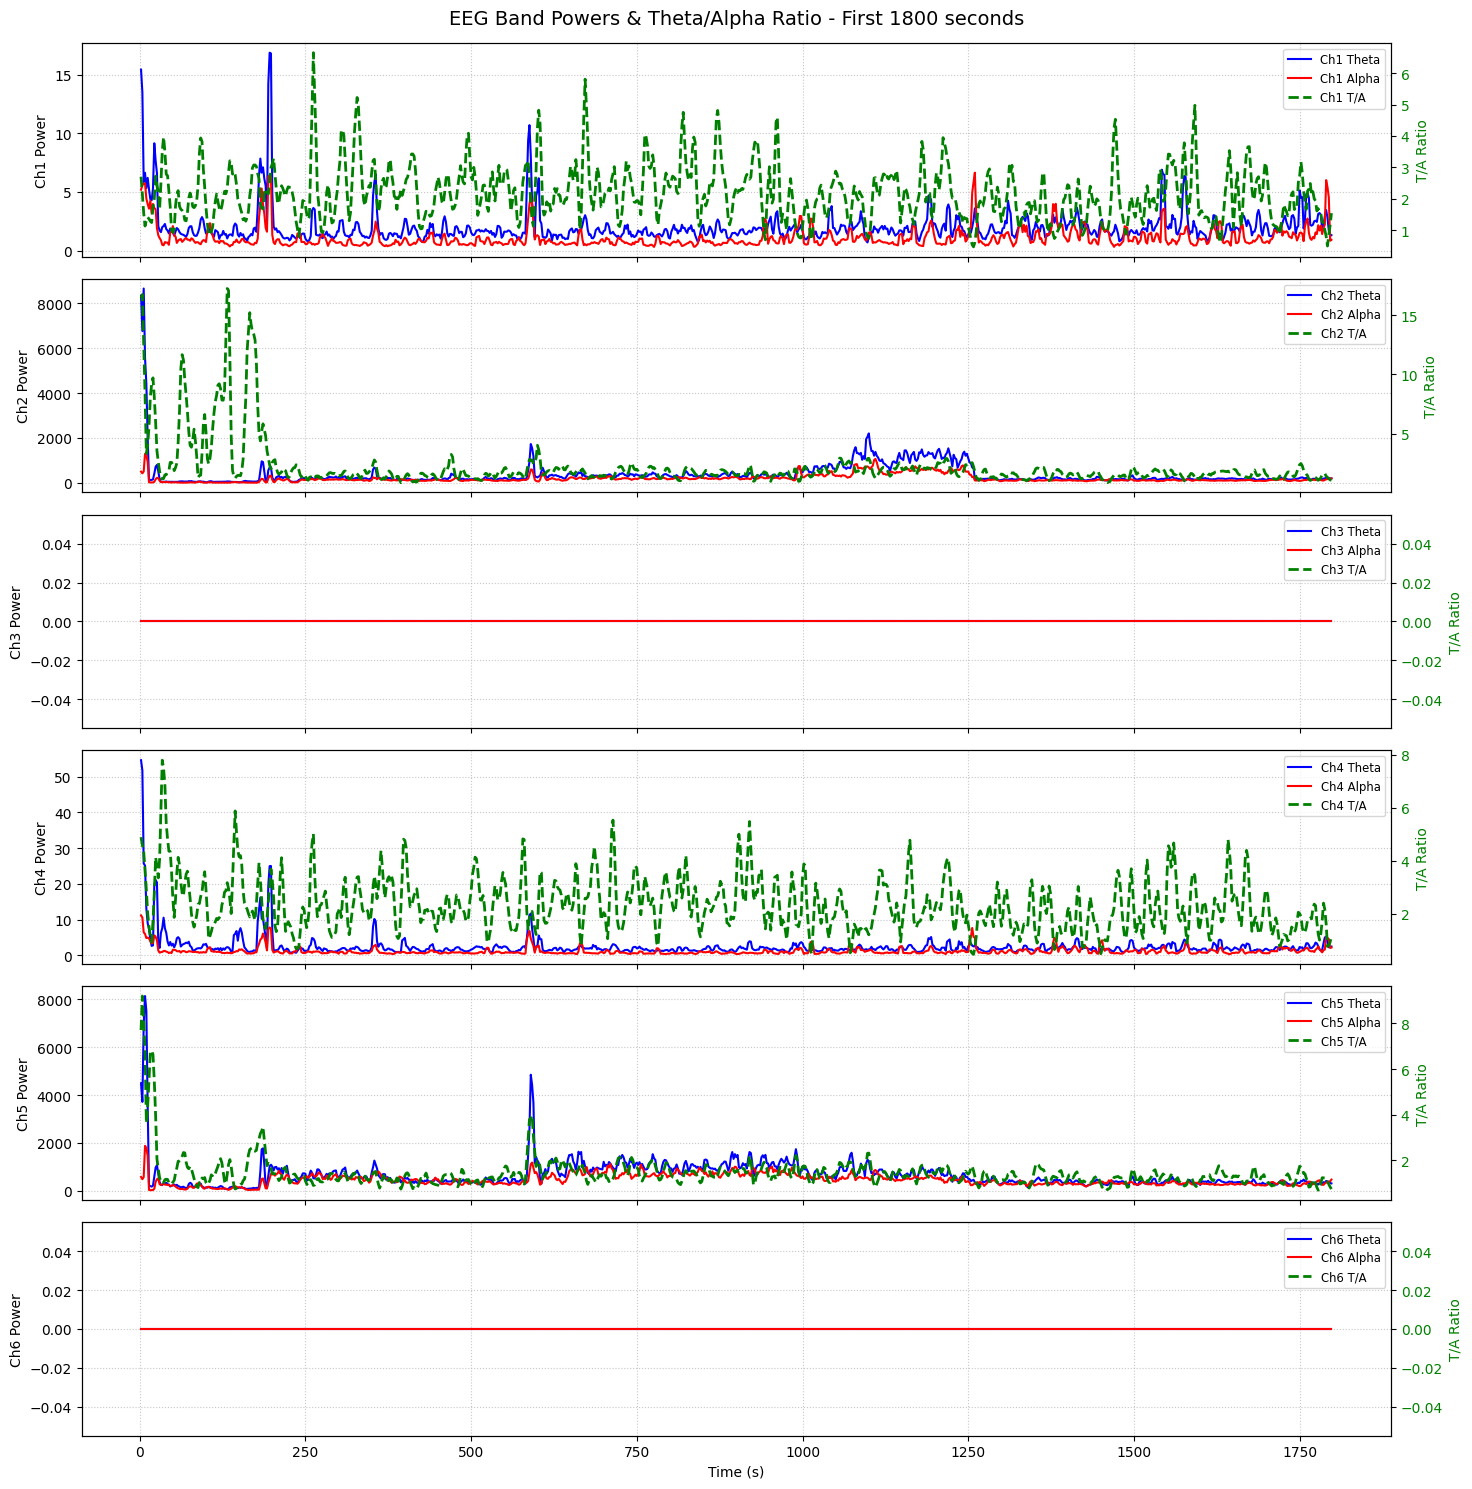


Visualization complete!


In [1]:
# Fast EEG Visualization Script with Full Preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, sosfilt, iirnotch, lfilter
from scipy import signal
import os
import sys
import yaml

# Add project path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the load_experiment function
from frenztoolkit.reader import load_experiment

# Configuration
SESSION_PATH = "/Users/yamachang/Downloads/neurozen_v6/data/DEID_Participants/DEID_P5/Session_1/1748972897.5852458"
VIZ_DURATION_SEC = 1800  # Visualize first 2 minutes for balance of speed vs insight

# Load configuration or use defaults
CONFIG_FILE_PATH = "../config.yaml"
try:
    with open(CONFIG_FILE_PATH, 'r') as f:
        config_yaml = yaml.safe_load(f)
    
    FS_EEG = config_yaml['signal_processing']['eeg']['sample_rate']
    EEG_ACTIVE_NAMES = config_yaml['signal_processing']['eeg']['active_channels_names']
    eeg_settings = config_yaml['signal_processing']['eeg']
    print(f"Loaded config: FS_EEG={FS_EEG}, Active channels: {EEG_ACTIVE_NAMES}")

except FileNotFoundError:
    print("Config not found, using defaults")
    FS_EEG = 128
    EEG_ACTIVE_NAMES = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6']
    eeg_settings = {
        'notch_freq': 60.0,
        'feature_window_sec': 4,
        'feature_overlap_ratio': 0.5,
        'psd_nperseg_sec': 4,
        'psd_overlap_ratio': 0.5,
        'theta_band_actual': [4.0, 8.0],
        'alpha_band': [8.0, 13.0],
        'eeg_uv_scaling_factor': 1.0
    }

# Import or define signal utilities
try:
    from src.utils.signal_utils import calculate_psd_welch, calculate_band_power
    print("Successfully imported signal_utils functions.")
except ImportError:
    print("Using fallback signal processing functions.")
    
    def calculate_psd_welch(data, fs, nperseg=None, noverlap=None):
        if nperseg is None:
            nperseg = min(len(data), fs * 2)
        if noverlap is None:
            noverlap = nperseg // 2
        freqs, psd = signal.welch(data, fs, nperseg=nperseg, noverlap=noverlap)
        return freqs, psd
    
    def calculate_band_power(freqs, psd, band):
        band_indices = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
        if len(band_indices) == 0:
            return 0.0
        return np.trapz(psd[band_indices], freqs[band_indices])

def fast_rolling_median_mad(data, window_size, update_every=128):
    """
    Fast rolling median/MAD calculation with sparse updates
    Only recalculates every 'update_every' samples for efficiency
    """
    n_samples = len(data)
    medians = np.zeros(n_samples)
    mads = np.ones(n_samples)  # Initialize to 1
    
    # Initialize first window
    if n_samples >= window_size:
        first_window = data[:window_size]
        medians[:window_size] = np.median(first_window)
        mads[:window_size] = np.median(np.abs(first_window - medians[0]))
        if mads[0] == 0:
            mads[:window_size] = 1.0
    
    # Update at sparse intervals
    for i in range(window_size, n_samples, update_every):
        end_idx = min(i + update_every, n_samples)
        start_window = max(0, i - window_size)
        
        window_data = data[start_window:i]
        median_val = np.median(window_data)
        mad_val = np.median(np.abs(window_data - median_val))
        if mad_val == 0:
            mad_val = 1.0
        
        # Fill the interval
        medians[i:end_idx] = median_val
        mads[i:end_idx] = mad_val
    
    return medians, mads

def fast_causal_eeg_pipeline(data, fs, notch_freq=60.0, bandpass_low=1.0, bandpass_high=40.0,
                           rolling_window_sec=30.0, mad_threshold=6.0, median_filter_size=5):
    """
    Fast vectorized causal EEG processing pipeline
    
    Args:
        data: EEG data (channels x samples)
        fs: Sampling rate
        
    Returns:
        processed_data: Cleaned EEG data
        artifact_flags: Boolean array indicating artifacts
        stats: Dictionary with processing statistics
    """
    print(f"Processing {data.shape} EEG data through fast causal pipeline...")
    
    num_channels, num_samples = data.shape
    processed_data = np.zeros_like(data)
    artifact_flags = np.zeros(data.shape, dtype=bool)
    
    # Design filters
    Q = 30.0
    notch_b, notch_a = iirnotch(notch_freq, Q, fs)
    bandpass_sos = butter(4, [bandpass_low, bandpass_high], btype='band', fs=fs, output='sos')
    
    rolling_window_size = int(rolling_window_sec * fs)
    update_interval = max(1, fs // 4)  # Update stats 4 times per second
    
    channel_stats = {}
    
    for ch_idx in range(num_channels):
        print(f"  Processing channel {ch_idx+1}/{num_channels}")
        
        # Step 1: Apply causal filters
        notch_filtered = lfilter(notch_b, notch_a, data[ch_idx, :])
        bandpass_filtered = sosfilt(bandpass_sos, notch_filtered)
        
        # Step 2: Fast rolling median/MAD calculation
        medians, mads = fast_rolling_median_mad(bandpass_filtered, rolling_window_size, update_interval)
        
        # Step 3: Artifact detection and clipping
        lower_bounds = medians - mad_threshold * mads
        upper_bounds = medians + mad_threshold * mads
        
        # Find artifacts
        artifacts = (bandpass_filtered < lower_bounds) | (bandpass_filtered > upper_bounds)
        artifact_flags[ch_idx, :] = artifacts
        
        # Clip artifacts
        clipped_data = np.clip(bandpass_filtered, lower_bounds, upper_bounds)
        
        # Step 4: Simple causal median filter (running median of last N samples)
        if median_filter_size > 1:
            median_filtered = np.copy(clipped_data)
            for i in range(median_filter_size, num_samples):
                window = clipped_data[i-median_filter_size+1:i+1]
                median_filtered[i] = np.median(window)
            processed_data[ch_idx, :] = median_filtered
        else:
            processed_data[ch_idx, :] = clipped_data
        
        # Store stats
        artifact_rate = np.mean(artifacts) * 100
        channel_stats[ch_idx] = {
            'artifact_rate': artifact_rate,
            'mean_mad': np.mean(mads),
            'mean_median': np.mean(medians)
        }
    
    # Calculate epoch quality (4-second epochs)
    epoch_size = int(4 * fs)
    num_epochs = num_samples // epoch_size
    epoch_quality = []
    
    for epoch_idx in range(num_epochs):
        start_idx = epoch_idx * epoch_size
        end_idx = start_idx + epoch_size
        
        epoch_artifacts = artifact_flags[:, start_idx:end_idx]
        epoch_artifact_rate = np.mean(epoch_artifacts)
        
        # Mark as good if <5% artifacts across all channels
        epoch_is_good = epoch_artifact_rate < 0.05
        epoch_quality.append(epoch_is_good)
    
    stats = {
        'channel_stats': channel_stats,
        'epoch_quality': epoch_quality,
        'total_artifact_rate': np.mean(artifact_flags) * 100,
        'good_epochs': sum(epoch_quality),
        'total_epochs': len(epoch_quality)
    }
    
    return processed_data, artifact_flags, stats

def plot_eeg_comparison(raw_data, processed_data, artifact_flags, channel_names, fs, 
                       title="Raw vs Processed EEG Data", time_window_sec=1800):
    """Plot comparison between raw and processed EEG data"""
    if raw_data is None or processed_data is None:
        print(f"Missing data for '{title}'.")
        return
    
    num_ch = raw_data.shape[0]
    samples_to_plot = min(int(time_window_sec * fs), raw_data.shape[1])
    time_vec = np.arange(samples_to_plot) / fs
    
    eff_ch_names = [f"Ch {i+1}" for i in range(num_ch)] if len(channel_names) != num_ch else channel_names
    
    fig, axs = plt.subplots(num_ch, 1, figsize=(16, 2.5 * num_ch), sharex=True)
    if num_ch == 1:
        axs = [axs]
    
    for i in range(num_ch):
        # Plot raw data
        axs[i].plot(time_vec, raw_data[i, :samples_to_plot], 
                   label=f'{eff_ch_names[i]} Raw', color='lightgray', alpha=0.7, linewidth=0.5)
        
        # Plot processed data
        axs[i].plot(time_vec, processed_data[i, :samples_to_plot], 
                   label=f'{eff_ch_names[i]} Processed', color='blue', linewidth=1.0)
        
        # Mark artifacts (sample every 10th artifact for performance)
        if artifact_flags is not None:
            artifact_indices = np.where(artifact_flags[i, :samples_to_plot])[0]
            if len(artifact_indices) > 0:
                # Sample artifacts for display (every 10th one to avoid overcrowding)
                display_indices = artifact_indices[::max(1, len(artifact_indices)//100)]
                artifact_times = time_vec[display_indices]
                artifact_values = processed_data[i, display_indices]
                axs[i].scatter(artifact_times, artifact_values, 
                             color='red', s=8, alpha=0.7, label='Artifacts', zorder=5)
        
        axs[i].set_ylabel(f"{eff_ch_names[i]} (µV)")
        axs[i].legend(loc='upper right', fontsize='small')
        axs[i].grid(True, ls=':', alpha=0.7)
    
    if num_ch > 0:
        axs[-1].set_xlabel("Time (seconds)")
    
    fig.suptitle(title, fontsize=16, y=0.99)
    fig.subplots_adjust(top=0.93, hspace=0.3)
    plt.show()

def calculate_and_plot_band_powers(processed_data, channel_names, fs, eeg_settings, time_window_sec=120):
    """Calculate and plot theta/alpha band powers over time"""
    
    max_samples = min(int(time_window_sec * fs), processed_data.shape[1])
    data_subset = processed_data[:, :max_samples]
    
    num_channels = data_subset.shape[0]
    
    # Band power calculation parameters
    window_sec = eeg_settings['feature_window_sec']
    overlap_ratio = eeg_settings['feature_overlap_ratio']
    window_samples = int(window_sec * fs)
    step_samples = int(window_samples * (1 - overlap_ratio))
    
    theta_band = tuple(eeg_settings['theta_band_actual'])
    alpha_band = tuple(eeg_settings['alpha_band'])
    
    timestamps = []
    band_powers = {name: {'theta': [], 'alpha': []} for name in channel_names[:num_channels]}
    
    print(f"Calculating band powers over {time_window_sec} seconds...")
    
    for start_idx in range(0, max_samples - window_samples + 1, step_samples):
        timestamps.append((start_idx + window_samples / 2) / fs)
        
        for i in range(num_channels):
            ch_name = channel_names[i] if i < len(channel_names) else f"Ch{i+1}"
            epoch_data = data_subset[i, start_idx : start_idx + window_samples]
            
            # Calculate PSD
            nperseg = min(len(epoch_data), int(eeg_settings['psd_nperseg_sec'] * fs))
            noverlap = int(nperseg * eeg_settings.get('psd_overlap_ratio', 0.5))
            
            if nperseg > 0:
                freqs, psd = calculate_psd_welch(epoch_data, fs, nperseg=nperseg, noverlap=noverlap)
                band_powers[ch_name]['theta'].append(calculate_band_power(freqs, psd, theta_band))
                band_powers[ch_name]['alpha'].append(calculate_band_power(freqs, psd, alpha_band))
            else:
                band_powers[ch_name]['theta'].append(np.nan)
                band_powers[ch_name]['alpha'].append(np.nan)
    
    # Smooth and calculate ratios
    smoothed_powers = {name: {'theta': [], 'alpha': []} for name in channel_names[:num_channels]}
    theta_alpha_ratios = {name: [] for name in channel_names[:num_channels]}
    
    SMOOTH_WIN = 3
    for ch_name in list(band_powers.keys()):
        for band in ['theta', 'alpha']:
            s = pd.Series(band_powers[ch_name][band])
            smoothed_powers[ch_name][band] = s.rolling(SMOOTH_WIN, center=True, min_periods=1).mean().to_numpy()
        
        th_s = smoothed_powers[ch_name]['theta']
        al_s = smoothed_powers[ch_name]['alpha']
        ratio = np.where((np.isnan(al_s)) | (np.isnan(th_s)) | (al_s < 1e-9), 
                       np.nan, th_s / (al_s + 1e-9))
        theta_alpha_ratios[ch_name] = pd.Series(ratio).rolling(SMOOTH_WIN, center=True, min_periods=1).mean().to_numpy()
    
    # Plot band powers and ratios
    fig, axs = plt.subplots(num_channels, 1, figsize=(15, 2.5 * num_channels), sharex=True)
    if num_channels == 1:
        axs = [axs]
    
    for i, ch_name in enumerate(list(smoothed_powers.keys())):
        ax_p = axs[i]
        ax_r = ax_p.twinx()
        
        # Plot band powers
        if timestamps and len(smoothed_powers[ch_name]['theta']) == len(timestamps):
            ax_p.plot(timestamps, smoothed_powers[ch_name]['theta'], 
                     label=f'{ch_name} Theta', c='b', lw=1.5)
        if timestamps and len(smoothed_powers[ch_name]['alpha']) == len(timestamps):
            ax_p.plot(timestamps, smoothed_powers[ch_name]['alpha'], 
                     label=f'{ch_name} Alpha', c='r', lw=1.5)
        
        # Plot theta/alpha ratio
        if timestamps and len(theta_alpha_ratios[ch_name]) == len(timestamps):
            ax_r.plot(timestamps, theta_alpha_ratios[ch_name], 
                     label=f'{ch_name} T/A', c='g', ls='--', lw=2)
        
        ax_p.set_ylabel(f'{ch_name} Power')
        ax_p.tick_params(axis='y', labelcolor='k')
        ax_p.grid(True, ls=':', alpha=0.7)
        ax_r.set_ylabel('T/A Ratio', color='g')
        ax_r.tick_params(axis='y', labelcolor='g')
        
        # Combine legends
        h1, l1 = ax_p.get_legend_handles_labels()
        h2, l2 = ax_r.get_legend_handles_labels()
        ax_p.legend(h1 + h2, l1 + l2, loc='upper right', fontsize='small')
    
    if num_channels > 0:
        axs[-1].set_xlabel("Time (s)")
    
    plt.suptitle(f"EEG Band Powers & Theta/Alpha Ratio - First {time_window_sec} seconds", 
                fontsize=14, y=0.99)
    plt.tight_layout()
    plt.show()

def main():
    # Load session data
    print(f"Loading session data from: {SESSION_PATH}")
    session_data = load_experiment(SESSION_PATH)
    
    # Extract EEG data
    eeg_data = session_data["DATA"]["RAW"]["EEG"]
    print(f"EEG data shape: {eeg_data.shape}")
    
    # Handle data shape - transpose if needed
    if eeg_data.shape[0] > eeg_data.shape[1]:
        eeg_data = eeg_data.T
        print(f"Transposed EEG data to shape: {eeg_data.shape}")
    
    # Limit to visualization duration for speed
    max_samples = min(int(VIZ_DURATION_SEC * FS_EEG), eeg_data.shape[1])
    eeg_subset = eeg_data[:, :max_samples]
    print(f"Processing subset: {eeg_subset.shape} ({max_samples/FS_EEG:.1f} seconds)")
    
    # Apply scaling if configured
    scaling_factor = eeg_settings.get('eeg_uv_scaling_factor', 1.0)
    eeg_subset_scaled = eeg_subset * scaling_factor
    
    # Apply full causal preprocessing pipeline
    import time
    start_time = time.time()
    
    processed_eeg, artifact_flags, processing_stats = fast_causal_eeg_pipeline(
        eeg_subset_scaled,
        fs=FS_EEG,
        notch_freq=eeg_settings['notch_freq'],
        bandpass_low=1.0,
        bandpass_high=40.0,
        rolling_window_sec=30.0,
        mad_threshold=6.0,
        median_filter_size=5
    )
    
    processing_time = time.time() - start_time
    print(f"Processing completed in {processing_time:.2f} seconds")
    
    # Print processing statistics
    print(f"\n=== Processing Statistics ===")
    print(f"Overall artifact rate: {processing_stats['total_artifact_rate']:.2f}%")
    print(f"Epoch quality: {processing_stats['good_epochs']}/{processing_stats['total_epochs']} good epochs")
    
    print(f"\nPer-channel artifact rates:")
    num_channels = eeg_subset.shape[0]
    effective_names = EEG_ACTIVE_NAMES[:num_channels] if len(EEG_ACTIVE_NAMES) >= num_channels else [f"Ch{i+1}" for i in range(num_channels)]
    
    for ch_idx in range(num_channels):
        ch_name = effective_names[ch_idx]
        stats = processing_stats['channel_stats'][ch_idx]
        print(f"  {ch_name}: {stats['artifact_rate']:.2f}% artifacts")
    
    # Plot raw vs processed comparison
    plot_eeg_comparison(eeg_subset_scaled, processed_eeg, artifact_flags, 
                       effective_names, FS_EEG, 
                       title=f"Raw vs Processed EEG - First {VIZ_DURATION_SEC} seconds")
    
    # Calculate and plot band powers
    calculate_and_plot_band_powers(processed_eeg, effective_names, FS_EEG, eeg_settings, VIZ_DURATION_SEC)
    
    print("\nVisualization complete!")

if __name__ == "__main__":
    main()

Loaded config: FS_EEG=125, Active channels: ['LF', 'RF', 'OTEL', 'OTER']
Successfully imported signal_utils functions.
Loading session data from: /Users/yamachang/Downloads/neurozen_v6/data/DEID_Participants/DEID_P5/Session_1/1748972897.5852458
Current version: 0.2.6
Original EEG data shape: (225126, 6)
Transposed EEG data to shape: (6, 225126)
Trimming 30 seconds from start and 30 seconds from end
Trimmed EEG data shape: (6, 217626) (1741.0 seconds)
Processing subset: (6, 217626) (1741.0 seconds)
Processing (6, 217626) EEG data through fast causal pipeline...
  Processing channel 1/6
  Processing channel 2/6
  Processing channel 3/6
  Processing channel 4/6
  Processing channel 5/6
  Processing channel 6/6
Processing completed in 12.63 seconds

=== Processing Statistics ===
Data trimming: 30s start + 30s end = 60s total removed
Overall artifact rate: 1.84%
Epoch quality: 422/435 good epochs

Per-channel artifact rates:
  Ch1: 1.13% artifacts
  Ch2: 3.80% artifacts
  Ch3: 0.00% artifac

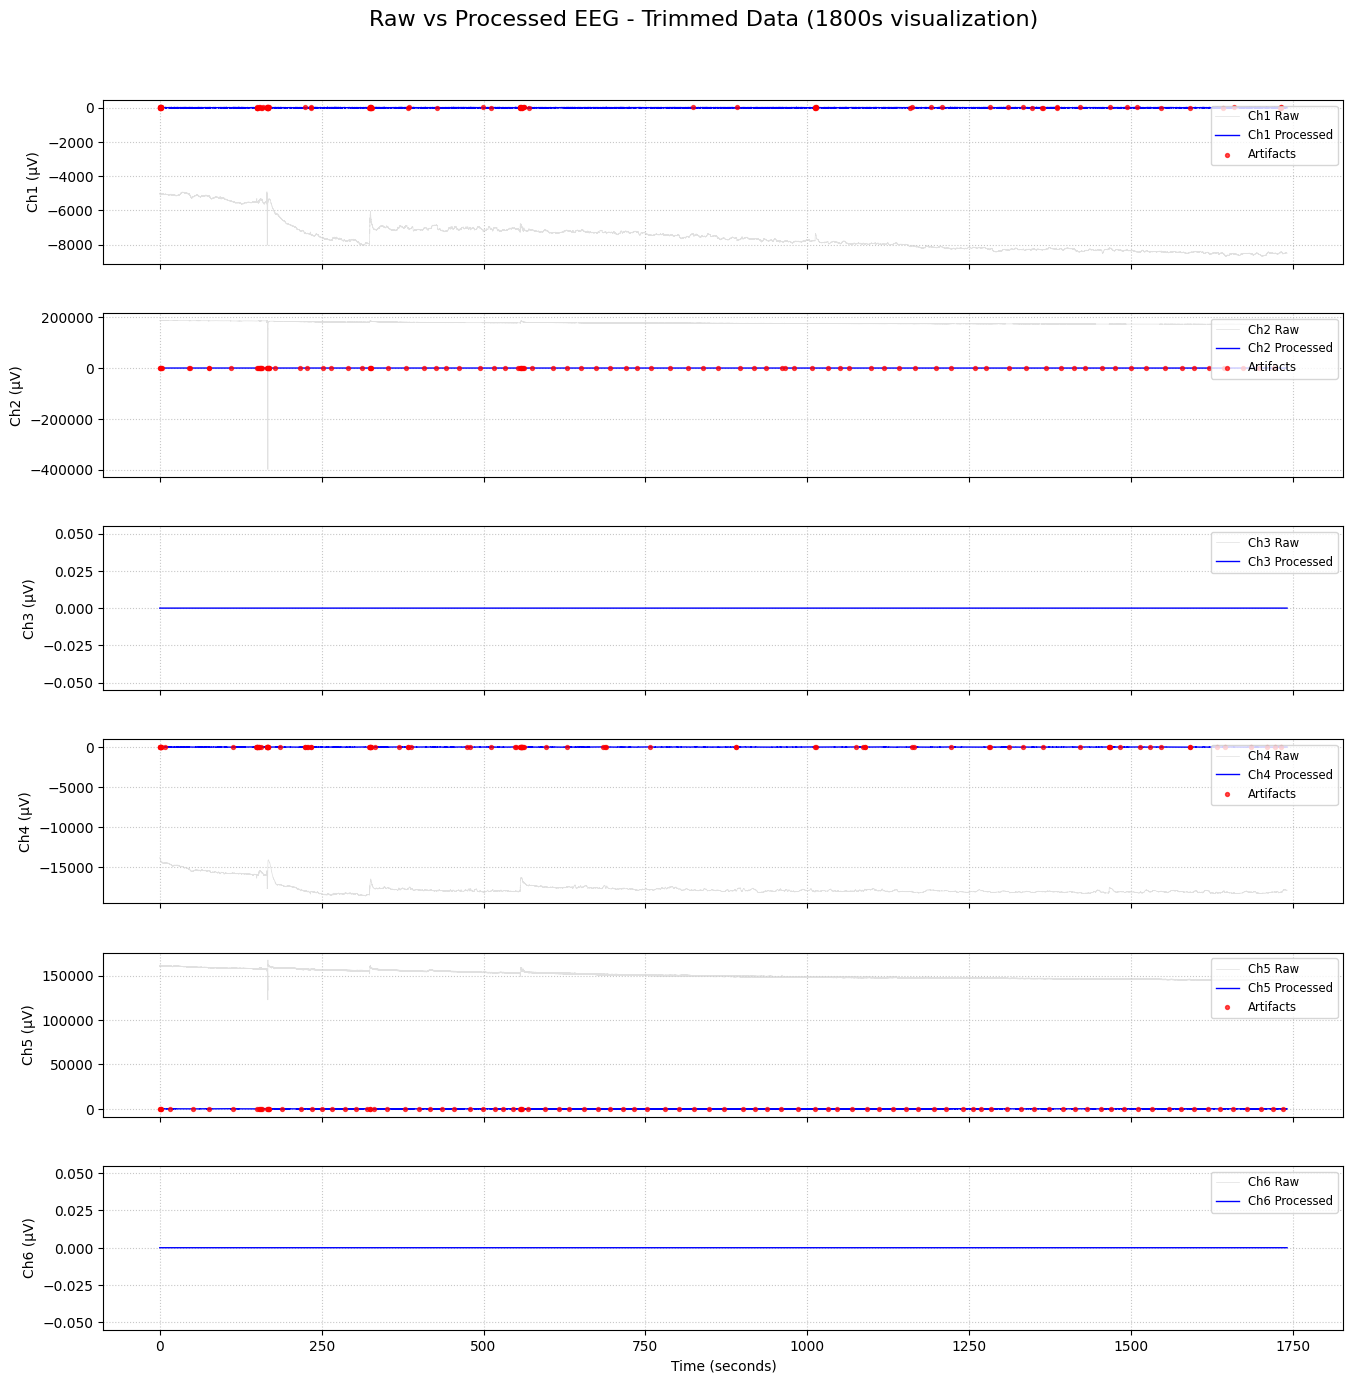

Calculating band powers over 1800 seconds...


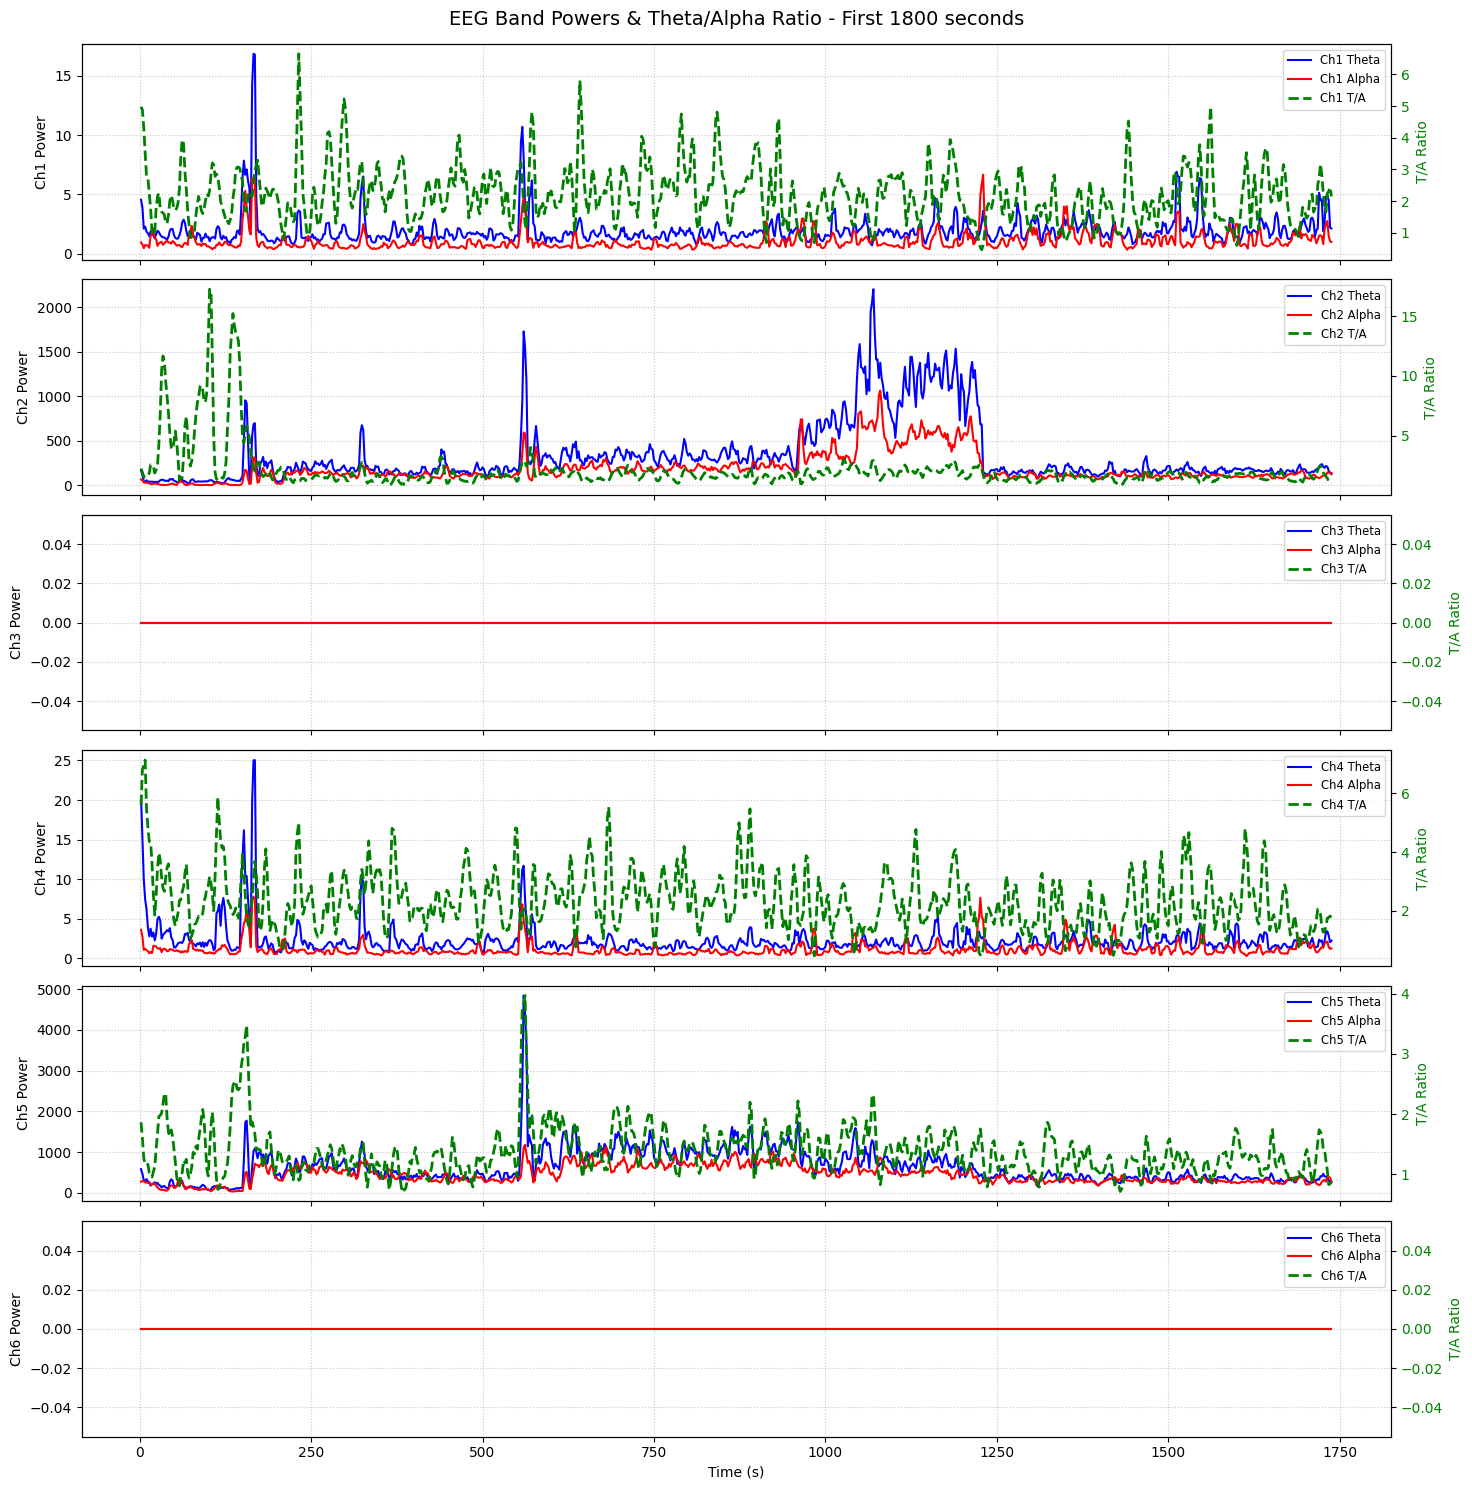


Visualization complete!


In [2]:
# Fast EEG Visualization Script with Full Preprocessing and Data Trimming
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, sosfilt, iirnotch, lfilter
from scipy import signal
import os
import sys
import yaml

# Add project path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the load_experiment function
from frenztoolkit.reader import load_experiment

# Configuration
SESSION_PATH = "/Users/yamachang/Downloads/neurozen_v6/data/DEID_Participants/DEID_P5/Session_1/1748972897.5852458"
VIZ_DURATION_SEC = 1800  # Visualize first 2 minutes for balance of speed vs insight

# Load configuration or use defaults
CONFIG_FILE_PATH = "../config.yaml"
try:
    with open(CONFIG_FILE_PATH, 'r') as f:
        config_yaml = yaml.safe_load(f)
    
    FS_EEG = config_yaml['signal_processing']['eeg']['sample_rate']
    EEG_ACTIVE_NAMES = config_yaml['signal_processing']['eeg']['active_channels_names']
    eeg_settings = config_yaml['signal_processing']['eeg']
    print(f"Loaded config: FS_EEG={FS_EEG}, Active channels: {EEG_ACTIVE_NAMES}")

except FileNotFoundError:
    print("Config not found, using defaults")
    FS_EEG = 128
    EEG_ACTIVE_NAMES = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6']
    eeg_settings = {
        'notch_freq': 60.0,
        'feature_window_sec': 4,
        'feature_overlap_ratio': 0.5,
        'psd_nperseg_sec': 4,
        'psd_overlap_ratio': 0.5,
        'theta_band_actual': [4.0, 8.0],
        'alpha_band': [8.0, 13.0],
        'eeg_uv_scaling_factor': 1.0
    }

# Import or define signal utilities
try:
    from src.utils.signal_utils import calculate_psd_welch, calculate_band_power
    print("Successfully imported signal_utils functions.")
except ImportError:
    print("Using fallback signal processing functions.")
    
    def calculate_psd_welch(data, fs, nperseg=None, noverlap=None):
        if nperseg is None:
            nperseg = min(len(data), fs * 2)
        if noverlap is None:
            noverlap = nperseg // 2
        freqs, psd = signal.welch(data, fs, nperseg=nperseg, noverlap=noverlap)
        return freqs, psd
    
    def calculate_band_power(freqs, psd, band):
        band_indices = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
        if len(band_indices) == 0:
            return 0.0
        return np.trapz(psd[band_indices], freqs[band_indices])

def fast_rolling_median_mad(data, window_size, update_every=128):
    """
    Fast rolling median/MAD calculation with sparse updates
    Only recalculates every 'update_every' samples for efficiency
    """
    n_samples = len(data)
    medians = np.zeros(n_samples)
    mads = np.ones(n_samples)  # Initialize to 1
    
    # Initialize first window
    if n_samples >= window_size:
        first_window = data[:window_size]
        medians[:window_size] = np.median(first_window)
        mads[:window_size] = np.median(np.abs(first_window - medians[0]))
        if mads[0] == 0:
            mads[:window_size] = 1.0
    
    # Update at sparse intervals
    for i in range(window_size, n_samples, update_every):
        end_idx = min(i + update_every, n_samples)
        start_window = max(0, i - window_size)
        
        window_data = data[start_window:i]
        median_val = np.median(window_data)
        mad_val = np.median(np.abs(window_data - median_val))
        if mad_val == 0:
            mad_val = 1.0
        
        # Fill the interval
        medians[i:end_idx] = median_val
        mads[i:end_idx] = mad_val
    
    return medians, mads

def fast_causal_eeg_pipeline(data, fs, notch_freq=60.0, bandpass_low=1.0, bandpass_high=40.0,
                           rolling_window_sec=30.0, mad_threshold=6.0, median_filter_size=5):
    """
    Fast vectorized causal EEG processing pipeline
    
    Args:
        data: EEG data (channels x samples)
        fs: Sampling rate
        
    Returns:
        processed_data: Cleaned EEG data
        artifact_flags: Boolean array indicating artifacts
        stats: Dictionary with processing statistics
    """
    print(f"Processing {data.shape} EEG data through fast causal pipeline...")
    
    num_channels, num_samples = data.shape
    processed_data = np.zeros_like(data)
    artifact_flags = np.zeros(data.shape, dtype=bool)
    
    # Design filters
    Q = 30.0
    notch_b, notch_a = iirnotch(notch_freq, Q, fs)
    bandpass_sos = butter(4, [bandpass_low, bandpass_high], btype='band', fs=fs, output='sos')
    
    rolling_window_size = int(rolling_window_sec * fs)
    update_interval = max(1, fs // 4)  # Update stats 4 times per second
    
    channel_stats = {}
    
    for ch_idx in range(num_channels):
        print(f"  Processing channel {ch_idx+1}/{num_channels}")
        
        # Step 1: Apply causal filters
        notch_filtered = lfilter(notch_b, notch_a, data[ch_idx, :])
        bandpass_filtered = sosfilt(bandpass_sos, notch_filtered)
        
        # Step 2: Fast rolling median/MAD calculation
        medians, mads = fast_rolling_median_mad(bandpass_filtered, rolling_window_size, update_interval)
        
        # Step 3: Artifact detection and clipping
        lower_bounds = medians - mad_threshold * mads
        upper_bounds = medians + mad_threshold * mads
        
        # Find artifacts
        artifacts = (bandpass_filtered < lower_bounds) | (bandpass_filtered > upper_bounds)
        artifact_flags[ch_idx, :] = artifacts
        
        # Clip artifacts
        clipped_data = np.clip(bandpass_filtered, lower_bounds, upper_bounds)
        
        # Step 4: Simple causal median filter (running median of last N samples)
        if median_filter_size > 1:
            median_filtered = np.copy(clipped_data)
            for i in range(median_filter_size, num_samples):
                window = clipped_data[i-median_filter_size+1:i+1]
                median_filtered[i] = np.median(window)
            processed_data[ch_idx, :] = median_filtered
        else:
            processed_data[ch_idx, :] = clipped_data
        
        # Store stats
        artifact_rate = np.mean(artifacts) * 100
        channel_stats[ch_idx] = {
            'artifact_rate': artifact_rate,
            'mean_mad': np.mean(mads),
            'mean_median': np.mean(medians)
        }
    
    # Calculate epoch quality (4-second epochs)
    epoch_size = int(4 * fs)
    num_epochs = num_samples // epoch_size
    epoch_quality = []
    
    for epoch_idx in range(num_epochs):
        start_idx = epoch_idx * epoch_size
        end_idx = start_idx + epoch_size
        
        epoch_artifacts = artifact_flags[:, start_idx:end_idx]
        epoch_artifact_rate = np.mean(epoch_artifacts)
        
        # Mark as good if <5% artifacts across all channels
        epoch_is_good = epoch_artifact_rate < 0.05
        epoch_quality.append(epoch_is_good)
    
    stats = {
        'channel_stats': channel_stats,
        'epoch_quality': epoch_quality,
        'total_artifact_rate': np.mean(artifact_flags) * 100,
        'good_epochs': sum(epoch_quality),
        'total_epochs': len(epoch_quality)
    }
    
    return processed_data, artifact_flags, stats

def plot_eeg_comparison(raw_data, processed_data, artifact_flags, channel_names, fs, 
                       title="Raw vs Processed EEG Data", time_window_sec=1800):
    """Plot comparison between raw and processed EEG data"""
    if raw_data is None or processed_data is None:
        print(f"Missing data for '{title}'.")
        return
    
    num_ch = raw_data.shape[0]
    samples_to_plot = min(int(time_window_sec * fs), raw_data.shape[1])
    time_vec = np.arange(samples_to_plot) / fs
    
    eff_ch_names = [f"Ch {i+1}" for i in range(num_ch)] if len(channel_names) != num_ch else channel_names
    
    fig, axs = plt.subplots(num_ch, 1, figsize=(16, 2.5 * num_ch), sharex=True)
    if num_ch == 1:
        axs = [axs]
    
    for i in range(num_ch):
        # Plot raw data
        axs[i].plot(time_vec, raw_data[i, :samples_to_plot], 
                   label=f'{eff_ch_names[i]} Raw', color='lightgray', alpha=0.7, linewidth=0.5)
        
        # Plot processed data
        axs[i].plot(time_vec, processed_data[i, :samples_to_plot], 
                   label=f'{eff_ch_names[i]} Processed', color='blue', linewidth=1.0)
        
        # Mark artifacts (sample every 10th artifact for performance)
        if artifact_flags is not None:
            artifact_indices = np.where(artifact_flags[i, :samples_to_plot])[0]
            if len(artifact_indices) > 0:
                # Sample artifacts for display (every 10th one to avoid overcrowding)
                display_indices = artifact_indices[::max(1, len(artifact_indices)//100)]
                artifact_times = time_vec[display_indices]
                artifact_values = processed_data[i, display_indices]
                axs[i].scatter(artifact_times, artifact_values, 
                             color='red', s=8, alpha=0.7, label='Artifacts', zorder=5)
        
        axs[i].set_ylabel(f"{eff_ch_names[i]} (µV)")
        axs[i].legend(loc='upper right', fontsize='small')
        axs[i].grid(True, ls=':', alpha=0.7)
    
    if num_ch > 0:
        axs[-1].set_xlabel("Time (seconds)")
    
    fig.suptitle(title, fontsize=16, y=0.99)
    fig.subplots_adjust(top=0.93, hspace=0.3)
    plt.show()

def calculate_and_plot_band_powers(processed_data, channel_names, fs, eeg_settings, time_window_sec=120):
    """Calculate and plot theta/alpha band powers over time"""
    
    max_samples = min(int(time_window_sec * fs), processed_data.shape[1])
    data_subset = processed_data[:, :max_samples]
    
    num_channels = data_subset.shape[0]
    
    # Band power calculation parameters
    window_sec = eeg_settings['feature_window_sec']
    overlap_ratio = eeg_settings['feature_overlap_ratio']
    window_samples = int(window_sec * fs)
    step_samples = int(window_samples * (1 - overlap_ratio))
    
    theta_band = tuple(eeg_settings['theta_band_actual'])
    alpha_band = tuple(eeg_settings['alpha_band'])
    
    timestamps = []
    band_powers = {name: {'theta': [], 'alpha': []} for name in channel_names[:num_channels]}
    
    print(f"Calculating band powers over {time_window_sec} seconds...")
    
    for start_idx in range(0, max_samples - window_samples + 1, step_samples):
        timestamps.append((start_idx + window_samples / 2) / fs)
        
        for i in range(num_channels):
            ch_name = channel_names[i] if i < len(channel_names) else f"Ch{i+1}"
            epoch_data = data_subset[i, start_idx : start_idx + window_samples]
            
            # Calculate PSD
            nperseg = min(len(epoch_data), int(eeg_settings['psd_nperseg_sec'] * fs))
            noverlap = int(nperseg * eeg_settings.get('psd_overlap_ratio', 0.5))
            
            if nperseg > 0:
                freqs, psd = calculate_psd_welch(epoch_data, fs, nperseg=nperseg, noverlap=noverlap)
                band_powers[ch_name]['theta'].append(calculate_band_power(freqs, psd, theta_band))
                band_powers[ch_name]['alpha'].append(calculate_band_power(freqs, psd, alpha_band))
            else:
                band_powers[ch_name]['theta'].append(np.nan)
                band_powers[ch_name]['alpha'].append(np.nan)
    
    # Smooth and calculate ratios
    smoothed_powers = {name: {'theta': [], 'alpha': []} for name in channel_names[:num_channels]}
    theta_alpha_ratios = {name: [] for name in channel_names[:num_channels]}
    
    SMOOTH_WIN = 3
    for ch_name in list(band_powers.keys()):
        for band in ['theta', 'alpha']:
            s = pd.Series(band_powers[ch_name][band])
            smoothed_powers[ch_name][band] = s.rolling(SMOOTH_WIN, center=True, min_periods=1).mean().to_numpy()
        
        th_s = smoothed_powers[ch_name]['theta']
        al_s = smoothed_powers[ch_name]['alpha']
        ratio = np.where((np.isnan(al_s)) | (np.isnan(th_s)) | (al_s < 1e-9), 
                       np.nan, th_s / (al_s + 1e-9))
        theta_alpha_ratios[ch_name] = pd.Series(ratio).rolling(SMOOTH_WIN, center=True, min_periods=1).mean().to_numpy()
    
    # Plot band powers and ratios
    fig, axs = plt.subplots(num_channels, 1, figsize=(15, 2.5 * num_channels), sharex=True)
    if num_channels == 1:
        axs = [axs]
    
    for i, ch_name in enumerate(list(smoothed_powers.keys())):
        ax_p = axs[i]
        ax_r = ax_p.twinx()
        
        # Plot band powers
        if timestamps and len(smoothed_powers[ch_name]['theta']) == len(timestamps):
            ax_p.plot(timestamps, smoothed_powers[ch_name]['theta'], 
                     label=f'{ch_name} Theta', c='b', lw=1.5)
        if timestamps and len(smoothed_powers[ch_name]['alpha']) == len(timestamps):
            ax_p.plot(timestamps, smoothed_powers[ch_name]['alpha'], 
                     label=f'{ch_name} Alpha', c='r', lw=1.5)
        
        # Plot theta/alpha ratio
        if timestamps and len(theta_alpha_ratios[ch_name]) == len(timestamps):
            ax_r.plot(timestamps, theta_alpha_ratios[ch_name], 
                     label=f'{ch_name} T/A', c='g', ls='--', lw=2)
        
        ax_p.set_ylabel(f'{ch_name} Power')
        ax_p.tick_params(axis='y', labelcolor='k')
        ax_p.grid(True, ls=':', alpha=0.7)
        ax_r.set_ylabel('T/A Ratio', color='g')
        ax_r.tick_params(axis='y', labelcolor='g')
        
        # Combine legends
        h1, l1 = ax_p.get_legend_handles_labels()
        h2, l2 = ax_r.get_legend_handles_labels()
        ax_p.legend(h1 + h2, l1 + l2, loc='upper right', fontsize='small')
    
    if num_channels > 0:
        axs[-1].set_xlabel("Time (s)")
    
    plt.suptitle(f"EEG Band Powers & Theta/Alpha Ratio - First {time_window_sec} seconds", 
                fontsize=14, y=0.99)
    plt.tight_layout()
    plt.show()

def main():
    # --- Get TRIM_SECONDS_START and TRIM_SECONDS_END ---
    # These should be defined in your Cell 2 (Data Loading & Trimming cell)
    # If they are not available in 'locals()', provide default values or ensure Cell 2 was run.
    if 'TRIM_SECONDS_START' in locals():
        current_trim_start = TRIM_SECONDS_START
    else:
        print("Warning: TRIM_SECONDS_START not found in locals. Assuming 30 seconds.")
        current_trim_start = 30

    if 'TRIM_SECONDS_END' in locals():
        current_trim_end = TRIM_SECONDS_END  # Not directly used in adjustment from start, but good to be aware of
    else:
        print("Warning: TRIM_SECONDS_END not found in locals. Assuming 30 seconds.")
        current_trim_end = 30
    
    # Load session data
    print(f"Loading session data from: {SESSION_PATH}")
    session_data = load_experiment(SESSION_PATH)
    
    # Extract EEG data
    eeg_data = session_data["DATA"]["RAW"]["EEG"]
    print(f"Original EEG data shape: {eeg_data.shape}")
    
    # Handle data shape - transpose if needed
    if eeg_data.shape[0] > eeg_data.shape[1]:
        eeg_data = eeg_data.T
        print(f"Transposed EEG data to shape: {eeg_data.shape}")
    
    # Apply data trimming
    print(f"Trimming {current_trim_start} seconds from start and {current_trim_end} seconds from end")
    
    # Calculate trim indices
    trim_start_samples = int(current_trim_start * FS_EEG)
    trim_end_samples = int(current_trim_end * FS_EEG)
    
    # Ensure we don't trim more data than we have
    total_samples = eeg_data.shape[1]
    if trim_start_samples + trim_end_samples >= total_samples:
        print(f"Warning: Trim duration ({current_trim_start + current_trim_end}s) is longer than total data ({total_samples/FS_EEG:.1f}s)")
        print("Using minimal trimming to preserve data.")
        trim_start_samples = min(trim_start_samples, total_samples // 4)
        trim_end_samples = min(trim_end_samples, total_samples // 4)
    
    # Apply trimming
    if trim_end_samples > 0:
        eeg_trimmed = eeg_data[:, trim_start_samples:-trim_end_samples]
    else:
        eeg_trimmed = eeg_data[:, trim_start_samples:]
    
    print(f"Trimmed EEG data shape: {eeg_trimmed.shape} ({eeg_trimmed.shape[1]/FS_EEG:.1f} seconds)")
    
    # Limit to visualization duration for speed (after trimming)
    max_samples = min(int(VIZ_DURATION_SEC * FS_EEG), eeg_trimmed.shape[1])
    eeg_subset = eeg_trimmed[:, :max_samples]
    print(f"Processing subset: {eeg_subset.shape} ({max_samples/FS_EEG:.1f} seconds)")
    
    # Apply scaling if configured
    scaling_factor = eeg_settings.get('eeg_uv_scaling_factor', 1.0)
    eeg_subset_scaled = eeg_subset * scaling_factor
    
    # Apply full causal preprocessing pipeline
    import time
    start_time = time.time()
    
    processed_eeg, artifact_flags, processing_stats = fast_causal_eeg_pipeline(
        eeg_subset_scaled,
        fs=FS_EEG,
        notch_freq=eeg_settings['notch_freq'],
        bandpass_low=1.0,
        bandpass_high=40.0,
        rolling_window_sec=30.0,
        mad_threshold=6.0,
        median_filter_size=5
    )
    
    processing_time = time.time() - start_time
    print(f"Processing completed in {processing_time:.2f} seconds")
    
    # Print processing statistics
    print(f"\n=== Processing Statistics ===")
    print(f"Data trimming: {current_trim_start}s start + {current_trim_end}s end = {current_trim_start + current_trim_end}s total removed")
    print(f"Overall artifact rate: {processing_stats['total_artifact_rate']:.2f}%")
    print(f"Epoch quality: {processing_stats['good_epochs']}/{processing_stats['total_epochs']} good epochs")
    
    print(f"\nPer-channel artifact rates:")
    num_channels = eeg_subset.shape[0]
    effective_names = EEG_ACTIVE_NAMES[:num_channels] if len(EEG_ACTIVE_NAMES) >= num_channels else [f"Ch{i+1}" for i in range(num_channels)]
    
    for ch_idx in range(num_channels):
        ch_name = effective_names[ch_idx]
        stats = processing_stats['channel_stats'][ch_idx]
        print(f"  {ch_name}: {stats['artifact_rate']:.2f}% artifacts")
    
    # Plot raw vs processed comparison
    plot_eeg_comparison(eeg_subset_scaled, processed_eeg, artifact_flags, 
                       effective_names, FS_EEG, 
                       title=f"Raw vs Processed EEG - Trimmed Data ({VIZ_DURATION_SEC}s visualization)")
    
    # Calculate and plot band powers
    calculate_and_plot_band_powers(processed_eeg, effective_names, FS_EEG, eeg_settings, VIZ_DURATION_SEC)
    
    print("\nVisualization complete!")

if __name__ == "__main__":
    main()

Current version: 0.2.6
Original EEG shape: (225126, 6)
Start time: 1748972897.5852458
Original focus list length: 859
Trimmed EEG shape: (217626, 6)
Removed 3750 samples from start and 3750 samples from end
Trimmed focus list length: 799
Removed 30 samples from start and 30 samples from end


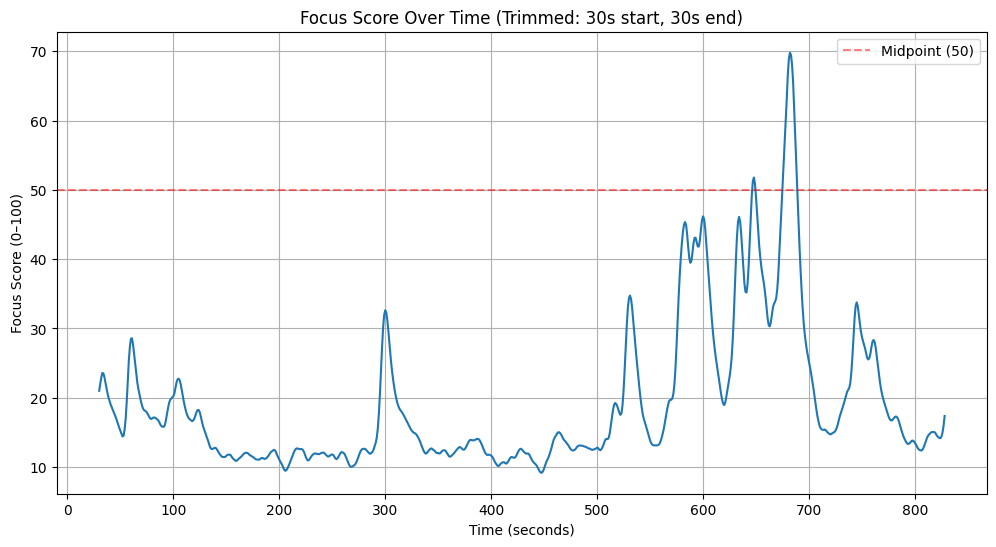


--- Trimmed Data Summary ---
EEG data duration: 1741.01 seconds
Focus data duration: 799.00 seconds
Focus score - Mean: 19.31, Std: 10.84
Focus score - Min: 9.17, Max: 69.79


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from frenztoolkit.reader import load_experiment

# --- Get TRIM_SECONDS_START and TRIM_SECONDS_END --- 
# These should be defined in your Cell 2 (Data Loading & Trimming cell)
# If they are not available in 'locals()', provide default values or ensure Cell 2 was run.
if 'TRIM_SECONDS_START' in locals():
    current_trim_start = TRIM_SECONDS_START
else:
    print("Warning: TRIM_SECONDS_START not found in locals. Assuming 30 seconds.")
    current_trim_start = 30
  
if 'TRIM_SECONDS_END' in locals():
    current_trim_end = TRIM_SECONDS_END
else:
    print("Warning: TRIM_SECONDS_END not found in locals. Assuming 30 seconds.")
    current_trim_end = 30

# Load the recorded session from your experiment folder
# find the folder contains your recorded data by timestamp
session_data = load_experiment("/Users/yamachang/Downloads/neurozen_v6/data/DEID_Participants/DEID_P5/Session_1/1748972897.5852458")

# Access EEG and Focus score history
eeg = session_data["DATA"]["RAW"]["EEG"]
print(f"Original EEG shape: {eeg.shape}")

focus_list = session_data["SCORE"]["array__focus_score"]
start_time = session_data["SCORE"]["start_time"]
print(f"Start time: {start_time}")
print(f"Original focus list length: {len(focus_list)}")

# --- TRIMMING LOGIC ---
# Assuming EEG sampling rate (you may need to adjust this based on your data)
# Common EEG sampling rates are 250, 500, or 1000 Hz
EEG_SAMPLING_RATE = 125  # Hz - adjust this to match your actual sampling rate

# For focus scores, determine the sampling rate
# This depends on how often focus scores are calculated
FOCUS_SAMPLING_RATE = 1  # Hz - assuming focus scores are calculated once per second

# Calculate trim samples for EEG
eeg_trim_start_samples = int(current_trim_start * EEG_SAMPLING_RATE)
eeg_trim_end_samples = int(current_trim_end * EEG_SAMPLING_RATE)

# Calculate trim samples for Focus scores
focus_trim_start_samples = int(current_trim_start * FOCUS_SAMPLING_RATE)
focus_trim_end_samples = int(current_trim_end * FOCUS_SAMPLING_RATE)

# Apply trimming to EEG data
if eeg.shape[0] > (eeg_trim_start_samples + eeg_trim_end_samples):
    eeg_trimmed = eeg[eeg_trim_start_samples:-eeg_trim_end_samples if eeg_trim_end_samples > 0 else None]
    print(f"Trimmed EEG shape: {eeg_trimmed.shape}")
    print(f"Removed {eeg_trim_start_samples} samples from start and {eeg_trim_end_samples} samples from end")
else:
    print("Warning: EEG data too short for trimming. Using original data.")
    eeg_trimmed = eeg

# Apply trimming to Focus scores
focus_array = np.array(focus_list).flatten()
if len(focus_array) > (focus_trim_start_samples + focus_trim_end_samples):
    focus_trimmed = focus_array[focus_trim_start_samples:-focus_trim_end_samples if focus_trim_end_samples > 0 else None]
    print(f"Trimmed focus list length: {len(focus_trimmed)}")
    print(f"Removed {focus_trim_start_samples} samples from start and {focus_trim_end_samples} samples from end")
else:
    print("Warning: Focus data too short for trimming. Using original data.")
    focus_trimmed = focus_array

# Create time axis for trimmed focus data
focus_time_axis = np.arange(len(focus_trimmed)) / FOCUS_SAMPLING_RATE + current_trim_start

# Plot the trimmed Focus score over time
plt.figure(figsize=(12, 6))
plt.plot(focus_time_axis, focus_trimmed)
plt.title(f"Focus Score Over Time (Trimmed: {current_trim_start}s start, {current_trim_end}s end)")
plt.xlabel("Time (seconds)")
plt.ylabel("Focus Score (0–100)")
plt.grid(True)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='Midpoint (50)')
plt.legend()
plt.show()

# Print summary statistics
print("\n--- Trimmed Data Summary ---")
print(f"EEG data duration: {len(eeg_trimmed) / EEG_SAMPLING_RATE:.2f} seconds")
print(f"Focus data duration: {len(focus_trimmed) / FOCUS_SAMPLING_RATE:.2f} seconds")
print(f"Focus score - Mean: {np.mean(focus_trimmed):.2f}, Std: {np.std(focus_trimmed):.2f}")
print(f"Focus score - Min: {np.min(focus_trimmed):.2f}, Max: {np.max(focus_trimmed):.2f}")

Loaded config: FS_EEG=125, Active channels: ['LF', 'RF', 'OTEL', 'OTER']
Successfully imported signal_utils functions.
Loading session data from: /Users/yamachang/Desktop/theta-meditation-project/data/test_session/1748578178.42679
Current version: 0.2.5
EEG data shape: (209340, 6)
Transposed EEG data to shape: (6, 209340)
Processing subset: (6, 209340) (1674.7 seconds)
Processing (6, 209340) EEG data through fast causal pipeline...
  Processing channel 1/6
    Applied MAD normalization to channel 1
  Processing channel 2/6
    Applied MAD normalization to channel 2
  Processing channel 3/6
    Applied MAD normalization to channel 3
  Processing channel 4/6
    Applied MAD normalization to channel 4
  Processing channel 5/6
    Applied MAD normalization to channel 5
  Processing channel 6/6
    Applied MAD normalization to channel 6
Processing completed in 11.93 seconds

=== Processing Statistics ===
Overall artifact rate: 2.70%
Epoch quality: 363/418 good epochs

Per-channel artifact r

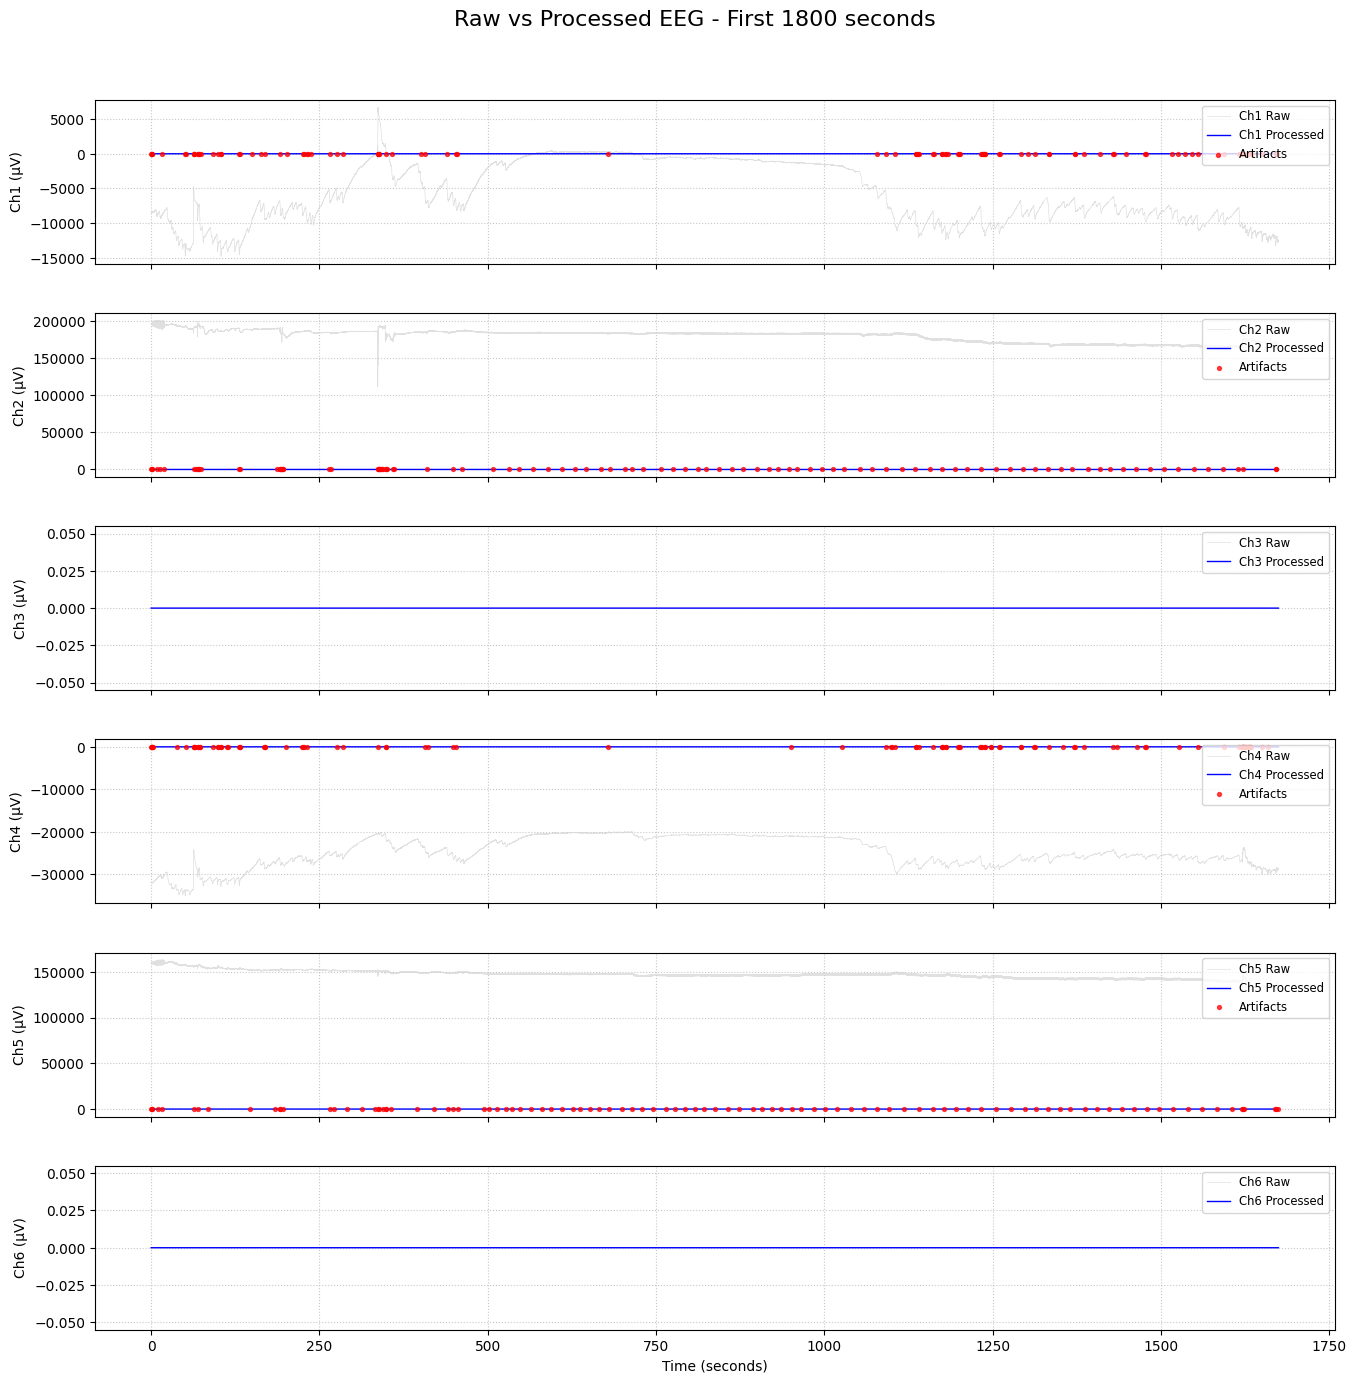

Calculating band powers over 1800 seconds...


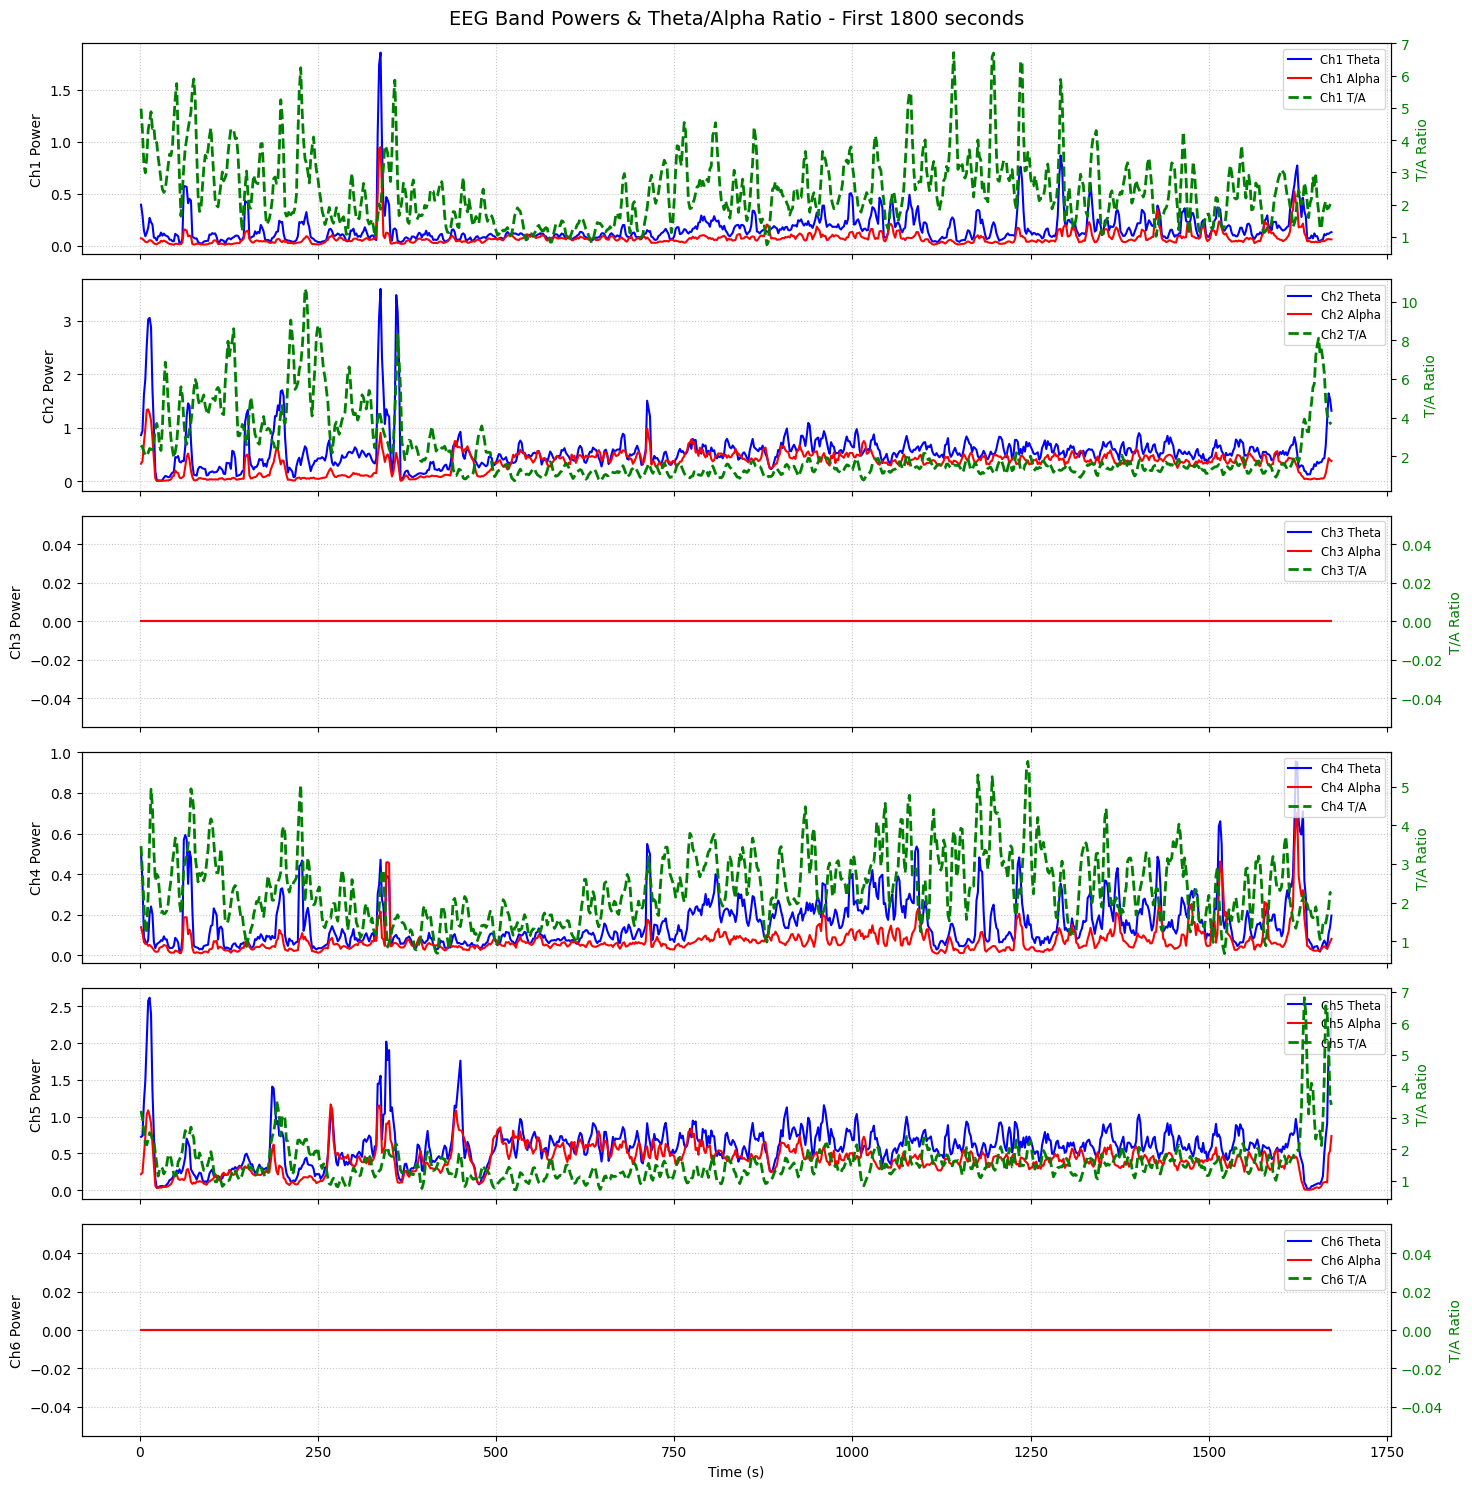


Visualization complete!


In [1]:
# Fast EEG Visualization Script with Full Preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, sosfilt, iirnotch, lfilter
from scipy import signal
import os
import sys
import yaml

# Add project path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the load_experiment function
from frenztoolkit.reader import load_experiment

# Configuration
SESSION_PATH = "/Users/yamachang/Desktop/theta-meditation-project/data/test_session/1748578178.42679"
VIZ_DURATION_SEC = 1800  # Visualize first 2 minutes for balance of speed vs insight

# Load configuration or use defaults
CONFIG_FILE_PATH = "../config.yaml"
try:
    with open(CONFIG_FILE_PATH, 'r') as f:
        config_yaml = yaml.safe_load(f)
    
    FS_EEG = config_yaml['signal_processing']['eeg']['sample_rate']
    EEG_ACTIVE_NAMES = config_yaml['signal_processing']['eeg']['active_channels_names']
    eeg_settings = config_yaml['signal_processing']['eeg']
    print(f"Loaded config: FS_EEG={FS_EEG}, Active channels: {EEG_ACTIVE_NAMES}")

except FileNotFoundError:
    print("Config not found, using defaults")
    FS_EEG = 125
    EEG_ACTIVE_NAMES = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6']
    eeg_settings = {
        'notch_freq': 60.0,
        'feature_window_sec': 4,
        'feature_overlap_ratio': 0.5,
        'psd_nperseg_sec': 4,
        'psd_overlap_ratio': 0.5,
        'theta_band_actual': [4.0, 8.0],
        'alpha_band': [8.0, 13.0],
        'eeg_uv_scaling_factor': 1.0
    }

# Import or define signal utilities
try:
    from src.utils.signal_utils import calculate_psd_welch, calculate_band_power
    print("Successfully imported signal_utils functions.")
except ImportError:
    print("Using fallback signal processing functions.")
    
    def calculate_psd_welch(data, fs, nperseg=None, noverlap=None):
        if nperseg is None:
            nperseg = min(len(data), fs * 2)
        if noverlap is None:
            noverlap = nperseg // 2
        freqs, psd = signal.welch(data, fs, nperseg=nperseg, noverlap=noverlap)
        return freqs, psd
    
    def calculate_band_power(freqs, psd, band):
        band_indices = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
        if len(band_indices) == 0:
            return 0.0
        return np.trapz(psd[band_indices], freqs[band_indices])

def fast_rolling_median_mad(data, window_size, update_every=125):
    """
    Fast rolling median/MAD calculation with sparse updates
    Only recalculates every 'update_every' samples for efficiency
    """
    n_samples = len(data)
    medians = np.zeros(n_samples)
    mads = np.ones(n_samples)  # Initialize to 1
    
    # Initialize first window
    if n_samples >= window_size:
        first_window = data[:window_size]
        medians[:window_size] = np.median(first_window)
        mads[:window_size] = np.median(np.abs(first_window - medians[0]))
        if mads[0] == 0:
            mads[:window_size] = 1.0
    
    # Update at sparse intervals
    for i in range(window_size, n_samples, update_every):
        end_idx = min(i + update_every, n_samples)
        start_window = max(0, i - window_size)
        
        window_data = data[start_window:i]
        median_val = np.median(window_data)
        mad_val = np.median(np.abs(window_data - median_val))
        if mad_val == 0:
            mad_val = 1.0
        
        # Fill the interval
        medians[i:end_idx] = median_val
        mads[i:end_idx] = mad_val
    
    return medians, mads

def fast_causal_eeg_pipeline(data, fs, notch_freq=60.0, bandpass_low=1.0, bandpass_high=40.0,
                           rolling_window_sec=30.0, mad_threshold=6.0, median_filter_size=5):
    """
    Fast vectorized causal EEG processing pipeline
    
    Args:
        data: EEG data (channels x samples)
        fs: Sampling rate
        
    Returns:
        processed_data: Cleaned EEG data
        artifact_flags: Boolean array indicating artifacts
        stats: Dictionary with processing statistics
    """
    print(f"Processing {data.shape} EEG data through fast causal pipeline...")
    
    num_channels, num_samples = data.shape
    processed_data = np.zeros_like(data)
    artifact_flags = np.zeros(data.shape, dtype=bool)
    
    # Design filters
    Q = 30.0
    notch_b, notch_a = iirnotch(notch_freq, Q, fs)
    bandpass_sos = butter(4, [bandpass_low, bandpass_high], btype='band', fs=fs, output='sos')
    
    rolling_window_size = int(rolling_window_sec * fs)
    update_interval = max(1, fs // 4)  # Update stats 4 times per second
    
    channel_stats = {}
    
    for ch_idx in range(num_channels):
        print(f"  Processing channel {ch_idx+1}/{num_channels}")
        
        # Step 1: Apply causal filters
        notch_filtered = lfilter(notch_b, notch_a, data[ch_idx, :])
        bandpass_filtered = sosfilt(bandpass_sos, notch_filtered)
        
        # Step 2: Fast rolling median/MAD calculation
        medians, mads = fast_rolling_median_mad(bandpass_filtered, rolling_window_size, update_interval)
        
        # Step 3: Artifact detection and clipping
        lower_bounds = medians - mad_threshold * mads
        upper_bounds = medians + mad_threshold * mads
        
        # Find artifacts
        artifacts = (bandpass_filtered < lower_bounds) | (bandpass_filtered > upper_bounds)
        artifact_flags[ch_idx, :] = artifacts
        
        # Clip artifacts
        clipped_data = np.clip(bandpass_filtered, lower_bounds, upper_bounds)
        
        # Step 3.5: MAD-based normalization (robust z-scoring)
        normalized_data = (clipped_data - medians) / mads
        print(f"    Applied MAD normalization to channel {ch_idx+1}")
        
        # Step 4: Simple causal median filter (running median of last N samples)
        if median_filter_size > 1:
            median_filtered = np.copy(normalized_data)
            for i in range(median_filter_size, num_samples):
                window = normalized_data[i-median_filter_size+1:i+1]
                median_filtered[i] = np.median(window)
            processed_data[ch_idx, :] = median_filtered
        else:
            processed_data[ch_idx, :] = normalized_data
        
        # Store stats
        artifact_rate = np.mean(artifacts) * 100
        channel_stats[ch_idx] = {
            'artifact_rate': artifact_rate,
            'mean_mad': np.mean(mads),
            'mean_median': np.mean(medians)
        }
    
    # Calculate epoch quality (4-second epochs)
    epoch_size = int(4 * fs)
    num_epochs = num_samples // epoch_size
    epoch_quality = []
    
    for epoch_idx in range(num_epochs):
        start_idx = epoch_idx * epoch_size
        end_idx = start_idx + epoch_size
        
        epoch_artifacts = artifact_flags[:, start_idx:end_idx]
        epoch_artifact_rate = np.mean(epoch_artifacts)
        
        # Mark as good if <5% artifacts across all channels
        epoch_is_good = epoch_artifact_rate < 0.05
        epoch_quality.append(epoch_is_good)
    
    stats = {
        'channel_stats': channel_stats,
        'epoch_quality': epoch_quality,
        'total_artifact_rate': np.mean(artifact_flags) * 100,
        'good_epochs': sum(epoch_quality),
        'total_epochs': len(epoch_quality)
    }
    
    return processed_data, artifact_flags, stats

def plot_eeg_comparison(raw_data, processed_data, artifact_flags, channel_names, fs, 
                       title="Raw vs Processed EEG Data", time_window_sec=1800):
    """Plot comparison between raw and processed EEG data"""
    if raw_data is None or processed_data is None:
        print(f"Missing data for '{title}'.")
        return
    
    num_ch = raw_data.shape[0]
    samples_to_plot = min(int(time_window_sec * fs), raw_data.shape[1])
    time_vec = np.arange(samples_to_plot) / fs
    
    eff_ch_names = [f"Ch {i+1}" for i in range(num_ch)] if len(channel_names) != num_ch else channel_names
    
    fig, axs = plt.subplots(num_ch, 1, figsize=(16, 2.5 * num_ch), sharex=True)
    if num_ch == 1:
        axs = [axs]
    
    for i in range(num_ch):
        # Plot raw data
        axs[i].plot(time_vec, raw_data[i, :samples_to_plot], 
                   label=f'{eff_ch_names[i]} Raw', color='lightgray', alpha=0.7, linewidth=0.5)
        
        # Plot processed data
        axs[i].plot(time_vec, processed_data[i, :samples_to_plot], 
                   label=f'{eff_ch_names[i]} Processed', color='blue', linewidth=1.0)
        
        # Mark artifacts (sample every 10th artifact for performance)
        if artifact_flags is not None:
            artifact_indices = np.where(artifact_flags[i, :samples_to_plot])[0]
            if len(artifact_indices) > 0:
                # Sample artifacts for display (every 10th one to avoid overcrowding)
                display_indices = artifact_indices[::max(1, len(artifact_indices)//100)]
                artifact_times = time_vec[display_indices]
                artifact_values = processed_data[i, display_indices]
                axs[i].scatter(artifact_times, artifact_values, 
                             color='red', s=8, alpha=0.7, label='Artifacts', zorder=5)
        
        axs[i].set_ylabel(f"{eff_ch_names[i]} (µV)")
        axs[i].legend(loc='upper right', fontsize='small')
        axs[i].grid(True, ls=':', alpha=0.7)
    
    if num_ch > 0:
        axs[-1].set_xlabel("Time (seconds)")
    
    fig.suptitle(title, fontsize=16, y=0.99)
    fig.subplots_adjust(top=0.93, hspace=0.3)
    plt.show()

def calculate_and_plot_band_powers(processed_data, channel_names, fs, eeg_settings, time_window_sec=120):
    """Calculate and plot theta/alpha band powers over time"""
    
    max_samples = min(int(time_window_sec * fs), processed_data.shape[1])
    data_subset = processed_data[:, :max_samples]
    
    num_channels = data_subset.shape[0]
    
    # Band power calculation parameters
    window_sec = eeg_settings['feature_window_sec']
    overlap_ratio = eeg_settings['feature_overlap_ratio']
    window_samples = int(window_sec * fs)
    step_samples = int(window_samples * (1 - overlap_ratio))
    
    theta_band = tuple(eeg_settings['theta_band_actual'])
    alpha_band = tuple(eeg_settings['alpha_band'])
    
    timestamps = []
    band_powers = {name: {'theta': [], 'alpha': []} for name in channel_names[:num_channels]}
    
    print(f"Calculating band powers over {time_window_sec} seconds...")
    
    for start_idx in range(0, max_samples - window_samples + 1, step_samples):
        timestamps.append((start_idx + window_samples / 2) / fs)
        
        for i in range(num_channels):
            ch_name = channel_names[i] if i < len(channel_names) else f"Ch{i+1}"
            epoch_data = data_subset[i, start_idx : start_idx + window_samples]
            
            # Calculate PSD
            nperseg = min(len(epoch_data), int(eeg_settings['psd_nperseg_sec'] * fs))
            noverlap = int(nperseg * eeg_settings.get('psd_overlap_ratio', 0.5))
            
            if nperseg > 0:
                freqs, psd = calculate_psd_welch(epoch_data, fs, nperseg=nperseg, noverlap=noverlap)
                band_powers[ch_name]['theta'].append(calculate_band_power(freqs, psd, theta_band))
                band_powers[ch_name]['alpha'].append(calculate_band_power(freqs, psd, alpha_band))
            else:
                band_powers[ch_name]['theta'].append(np.nan)
                band_powers[ch_name]['alpha'].append(np.nan)
    
    # Smooth and calculate ratios
    smoothed_powers = {name: {'theta': [], 'alpha': []} for name in channel_names[:num_channels]}
    theta_alpha_ratios = {name: [] for name in channel_names[:num_channels]}
    
    SMOOTH_WIN = 3
    for ch_name in list(band_powers.keys()):
        for band in ['theta', 'alpha']:
            s = pd.Series(band_powers[ch_name][band])
            smoothed_powers[ch_name][band] = s.rolling(SMOOTH_WIN, center=True, min_periods=1).mean().to_numpy()
        
        th_s = smoothed_powers[ch_name]['theta']
        al_s = smoothed_powers[ch_name]['alpha']
        ratio = np.where((np.isnan(al_s)) | (np.isnan(th_s)) | (al_s < 1e-9), 
                       np.nan, th_s / (al_s + 1e-9))
        theta_alpha_ratios[ch_name] = pd.Series(ratio).rolling(SMOOTH_WIN, center=True, min_periods=1).mean().to_numpy()
    
    # Plot band powers and ratios
    fig, axs = plt.subplots(num_channels, 1, figsize=(15, 2.5 * num_channels), sharex=True)
    if num_channels == 1:
        axs = [axs]
    
    for i, ch_name in enumerate(list(smoothed_powers.keys())):
        ax_p = axs[i]
        ax_r = ax_p.twinx()
        
        # Plot band powers
        if timestamps and len(smoothed_powers[ch_name]['theta']) == len(timestamps):
            ax_p.plot(timestamps, smoothed_powers[ch_name]['theta'], 
                     label=f'{ch_name} Theta', c='b', lw=1.5)
        if timestamps and len(smoothed_powers[ch_name]['alpha']) == len(timestamps):
            ax_p.plot(timestamps, smoothed_powers[ch_name]['alpha'], 
                     label=f'{ch_name} Alpha', c='r', lw=1.5)
        
        # Plot theta/alpha ratio
        if timestamps and len(theta_alpha_ratios[ch_name]) == len(timestamps):
            ax_r.plot(timestamps, theta_alpha_ratios[ch_name], 
                     label=f'{ch_name} T/A', c='g', ls='--', lw=2)
        
        ax_p.set_ylabel(f'{ch_name} Power')
        ax_p.tick_params(axis='y', labelcolor='k')
        ax_p.grid(True, ls=':', alpha=0.7)
        ax_r.set_ylabel('T/A Ratio', color='g')
        ax_r.tick_params(axis='y', labelcolor='g')
        
        # Combine legends
        h1, l1 = ax_p.get_legend_handles_labels()
        h2, l2 = ax_r.get_legend_handles_labels()
        ax_p.legend(h1 + h2, l1 + l2, loc='upper right', fontsize='small')
    
    if num_channels > 0:
        axs[-1].set_xlabel("Time (s)")
    
    plt.suptitle(f"EEG Band Powers & Theta/Alpha Ratio - First {time_window_sec} seconds", 
                fontsize=14, y=0.99)
    plt.tight_layout()
    plt.show()

def main():
    # Load session data
    print(f"Loading session data from: {SESSION_PATH}")
    session_data = load_experiment(SESSION_PATH)
    
    # Extract EEG data
    eeg_data = session_data["DATA"]["RAW"]["EEG"]
    print(f"EEG data shape: {eeg_data.shape}")
    
    # Handle data shape - transpose if needed
    if eeg_data.shape[0] > eeg_data.shape[1]:
        eeg_data = eeg_data.T
        print(f"Transposed EEG data to shape: {eeg_data.shape}")
    
    # Limit to visualization duration for speed
    max_samples = min(int(VIZ_DURATION_SEC * FS_EEG), eeg_data.shape[1])
    eeg_subset = eeg_data[:, :max_samples]
    print(f"Processing subset: {eeg_subset.shape} ({max_samples/FS_EEG:.1f} seconds)")
    
    # Apply scaling if configured
    scaling_factor = eeg_settings.get('eeg_uv_scaling_factor', 1.0)
    eeg_subset_scaled = eeg_subset * scaling_factor
    
    # Apply full causal preprocessing pipeline
    import time
    start_time = time.time()
    
    processed_eeg, artifact_flags, processing_stats = fast_causal_eeg_pipeline(
        eeg_subset_scaled,
        fs=FS_EEG,
        notch_freq=eeg_settings['notch_freq'],
        bandpass_low=1.0,
        bandpass_high=40.0,
        rolling_window_sec=30.0,
        mad_threshold=6.0,
        median_filter_size=5
    )
    
    processing_time = time.time() - start_time
    print(f"Processing completed in {processing_time:.2f} seconds")
    
    # Print processing statistics
    print(f"\n=== Processing Statistics ===")
    print(f"Overall artifact rate: {processing_stats['total_artifact_rate']:.2f}%")
    print(f"Epoch quality: {processing_stats['good_epochs']}/{processing_stats['total_epochs']} good epochs")
    
    print(f"\nPer-channel artifact rates:")
    num_channels = eeg_subset.shape[0]
    effective_names = EEG_ACTIVE_NAMES[:num_channels] if len(EEG_ACTIVE_NAMES) >= num_channels else [f"Ch{i+1}" for i in range(num_channels)]
    
    for ch_idx in range(num_channels):
        ch_name = effective_names[ch_idx]
        stats = processing_stats['channel_stats'][ch_idx]
        print(f"  {ch_name}: {stats['artifact_rate']:.2f}% artifacts")
    
    # Plot raw vs processed comparison
    plot_eeg_comparison(eeg_subset_scaled, processed_eeg, artifact_flags, 
                       effective_names, FS_EEG, 
                       title=f"Raw vs Processed EEG - First {VIZ_DURATION_SEC} seconds")
    
    # Calculate and plot band powers
    calculate_and_plot_band_powers(processed_eeg, effective_names, FS_EEG, eeg_settings, VIZ_DURATION_SEC)
    
    print("\nVisualization complete!")

if __name__ == "__main__":
    main()